<a href="https://colab.research.google.com/github/psbruno/Redes-Neurais/blob/main/VAE_Bruno_Pires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>
Variational Autoencoder - Bruno Pires RA 139892
</h1>

<p>
Os autoenconders, redes neurais de aprendizado não supervisionado com estrutura muito semelhantes as redes MLP, é uma técnica que tem como objetivo projetar as suas entradas na saída após codificá-las, para que um espaço latente seja criado a partir da entrada,e logo em seguida, definir a saída por meio de uma reconstituição desse espaço.

As duas principais partes que compõem um autoenconder são:


*   Codificador, ou encoder - Responsável pela criação do espaço latente a partir da entrada, ou como o próprio nome já sugere, codifica essa entrada de tal forma que um espaço interessante seja criado. Pode ser vista como uma função de codificação, C = f( input ).
*   Decodificador, ou decoder - Responsável por exatamente o contrário: Sair do espaço latente, reconstruindo as entradas, sendo que também funciona como uma função, onde um output O é gerado é gerado a partir do espaço latente, EL, mais ou menos como O = g(EL)  


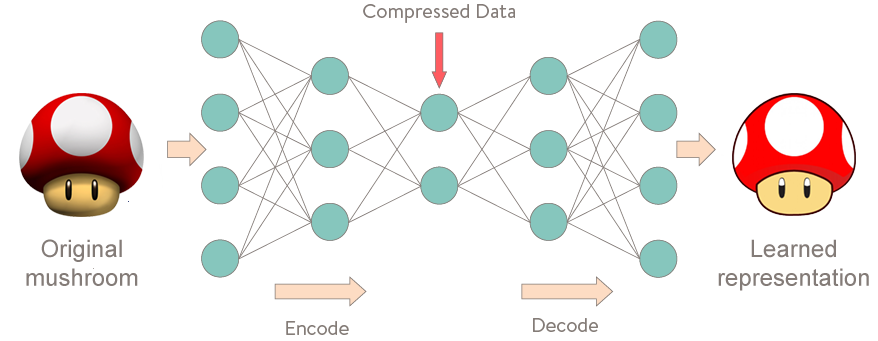



Esquematização de um AutoEncoder. Fonte - [Introdução sobre AutoEncoders ](https://www.deeplearningbook.com.br/introducao-aos-autoencoders/)
</p>

<p>
No código em questão, utilizaremos o Variational AutoEncoder, o VAE. Essa rede não deixa de ser um autoencoder, porém, o espaço criado é regularizado, onde existem propriedades que garantem correlações e uma linearidade entre os pontos dele, assim, as variações existentes podem ser visualizadas com mais detalhes, além de agrupadas de forma que conclusões possam ser extraidas.
</p>


<h2>
Datasets utilizados e códigos auxiliares
</h2>
<p>
Datasets: Variações do banco de dados de dígitos manuscritos MNIST, sendo eles o KMINST, sequência de imagens baseados em dos silabários, o hiragana, da língua japonesa, além do EMNIST, uma extensão do MNIST original.

Fontes
*   [MNIST datasets](https://analyticsindiamag.com/mnist/)
*   [Tensor Flow - KMNIST](https://www.tensorflow.org/datasets/catalog/kmnist)
*   [Tensor Flow - EMNIST](https://www.tensorflow.org/datasets/catalog/emnist)


</p>

In [ ]:
import torch
import torchvision
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from torchvision.datasets import KMNIST
from torchvision.datasets import EMNIST
from sklearn.decomposition import PCA

#Funções para implementação do VAE

[Fonte - Tutorial VAE pytorch](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/11-VAE.ipynb), adaptando para que o PCA seja o algoritmo de redução de dimensões



In [ ]:

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')
def loss_function(x_hat, x, mu, logvar, β=1):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + β * KLD
class VAE(nn.Module):
    def __init__(self,d=20):
        super().__init__()
        self.d = d
        self.encoder = nn.Sequential(
            nn.Linear(784, self.d ** 2),
            nn.ReLU(),
            nn.Linear(self.d ** 2, self.d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.d, self.d ** 2),
            nn.ReLU(),
            nn.Linear(self.d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar


In [ ]:
def execute(
            train_loader,
            test_loader,
            epochs =50,
            learning_rate = 1e-3
            ):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = VAE().to(device)
  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate,
  )

  codes = dict(μ=list(), logσ2=list(), y=list())
  for epoch in range(0, epochs + 1):
      if epoch > 0:
          model.train()
          train_loss = 0
          for x, _ in train_loader:
              x = x.to(device)
              # ===================forward=====================
              x_hat, mu, logvar = model(x)
              loss = loss_function(x_hat, x, mu, logvar)
              train_loss += loss.item()
              # ===================backward====================
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

      means, logvars, labels = list(), list(), list()
      with torch.no_grad():
          model.eval()
          test_loss = 0
          for x, y in test_loader:
              x = x.to(device)
              # ===================forward=====================
              x_hat, mu, logvar = model(x)
              test_loss += loss_function(x_hat, x, mu, logvar).item()
              # =====================log=======================
              means.append(mu.detach())
              logvars.append(logvar.detach())
              labels.append(y.detach())

      codes['μ'].append(torch.cat(means))
      codes['logσ2'].append(torch.cat(logvars))
      codes['y'].append(torch.cat(labels))
      test_loss /= len(test_loader.dataset)
      print(f'====> Test set loss: {test_loss:.4f}')
      display_images(x, x_hat, 1, f'Epoch {epoch}')

  return codes

In [ ]:
def plot(codes):
  X, Y, E = list(), list(), list()
  N = 1000  # samples per epoch
  epochs = (0, 5, 10)
  for epoch in epochs:
      X.append(codes['μ'][epoch][:N])
      E.append(PCA(n_components=2).fit_transform(X[-1].detach().cpu()))
      Y.append(codes['y'][epoch][:N])
  f, a = plt.subplots(ncols=3)
  for i, e in enumerate(epochs):
      s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
      a[i].grid(False)
      a[i].set_title(f'Epoch {e}')
      a[i].axis('equal')
  f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

#KMNIST


##Simulação 1

<p>
Nessas duas primeiras simulações, as entradas utilizadas foram do dataset KMINST. A seguir podemos ter uma pequena amostra dessas imagens que foram utilizadas
<p>

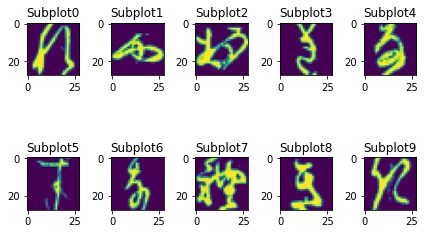

In [ ]:
inputSet = datasets.KMNIST('./data/', download=True, train=True, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))]))
fig=plt.figure()
axes = []
for a in range(10):
    axes.append( fig.add_subplot(2, 5, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)
    plt.imshow(inputSet.data[a])

fig.tight_layout()
plt.show()


<p>

Executando o modelo com 15 gerações, podemos ver as saídas geradas pelo decodificador

</p>

====> Test set loss: 543.7198
====> Epoch: 1 Average loss: 300.6560
====> Test set loss: 251.7286
====> Epoch: 2 Average loss: 237.0116
====> Test set loss: 226.7331
====> Epoch: 3 Average loss: 222.5055
====> Test set loss: 219.4498
====> Epoch: 4 Average loss: 217.0393
====> Test set loss: 217.1914
====> Epoch: 5 Average loss: 213.6897
====> Test set loss: 214.5441
====> Epoch: 6 Average loss: 211.5076
====> Test set loss: 212.6561
====> Epoch: 7 Average loss: 209.8499
====> Test set loss: 211.0402
====> Epoch: 8 Average loss: 208.5624
====> Test set loss: 210.3877
====> Epoch: 9 Average loss: 207.5289
====> Test set loss: 210.0928
====> Epoch: 10 Average loss: 206.6170
====> Test set loss: 208.9437


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


====> Epoch: 11 Average loss: 205.8945
====> Test set loss: 207.4683
====> Epoch: 12 Average loss: 205.2527
====> Test set loss: 207.6516
====> Epoch: 13 Average loss: 204.6308
====> Test set loss: 207.3476
====> Epoch: 14 Average loss: 204.2102
====> Test set loss: 206.4738
====> Epoch: 15 Average loss: 203.7339
====> Test set loss: 206.8827


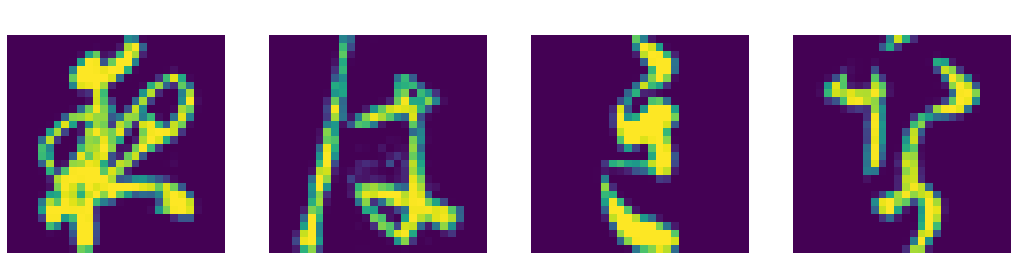

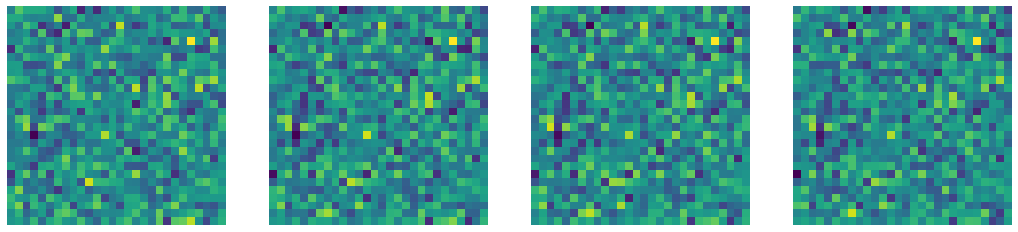

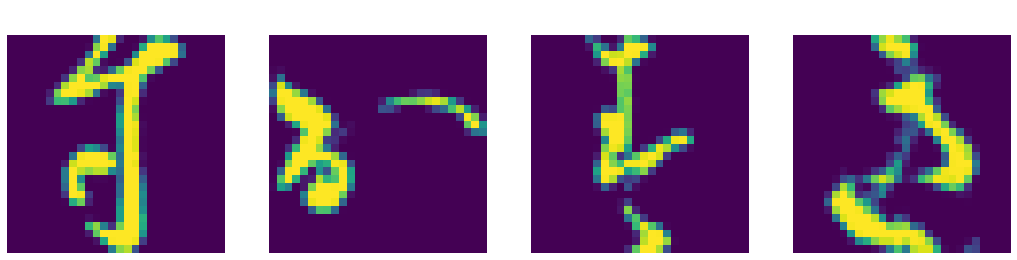

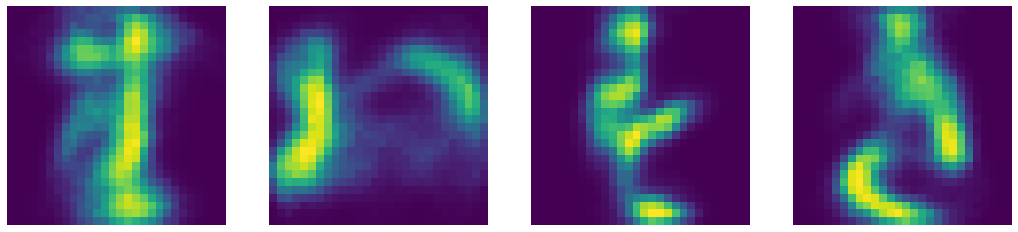

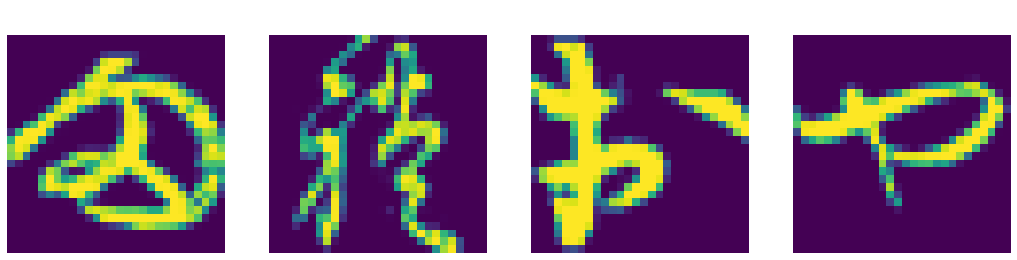

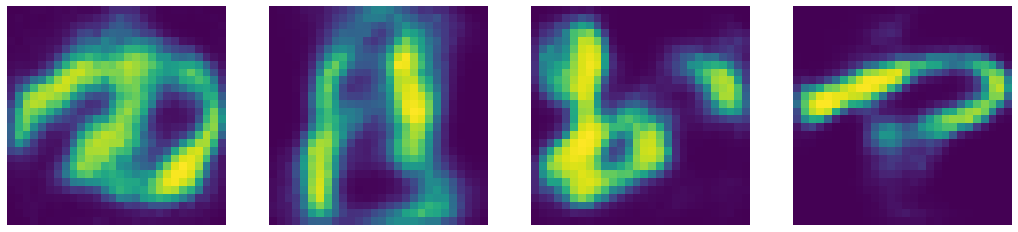

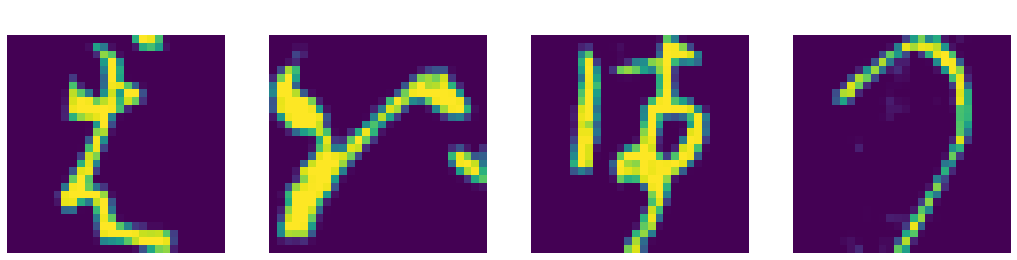

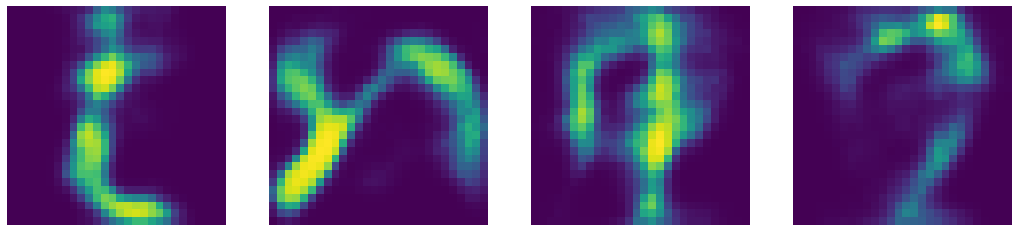

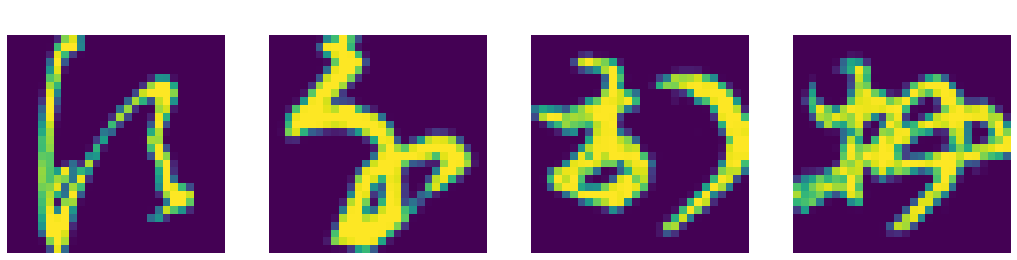

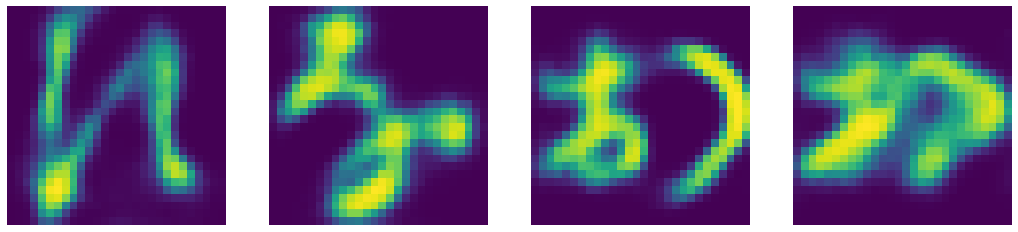

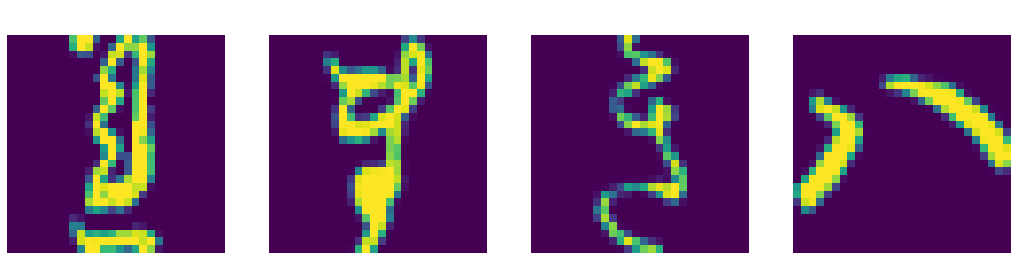

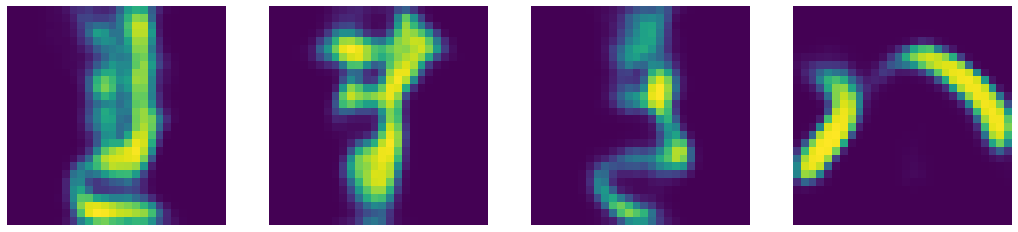

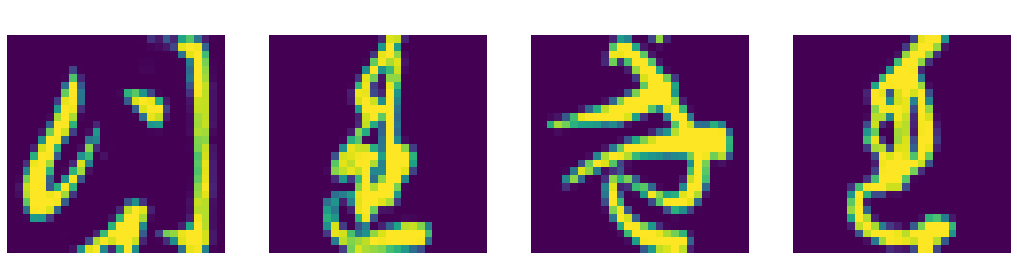

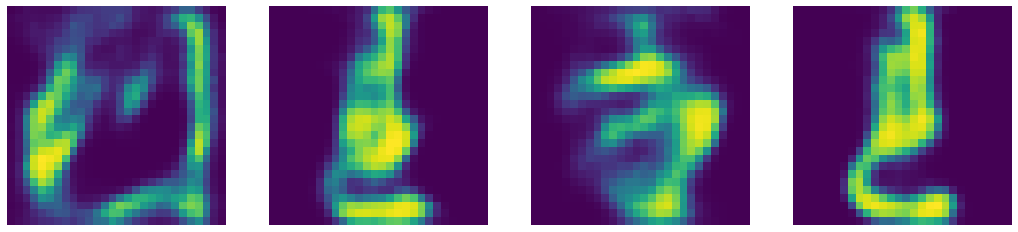

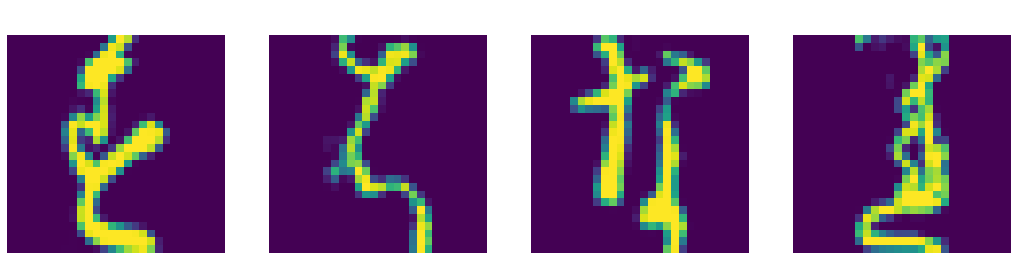

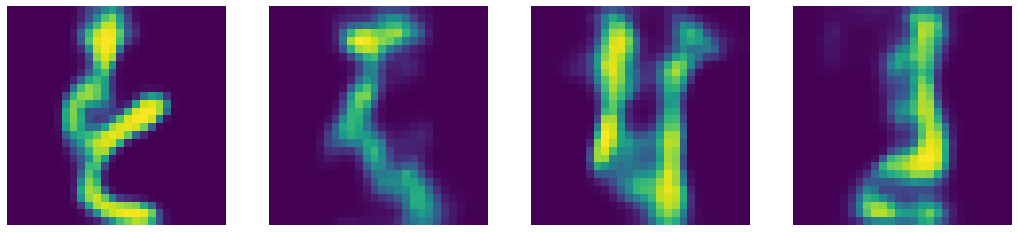

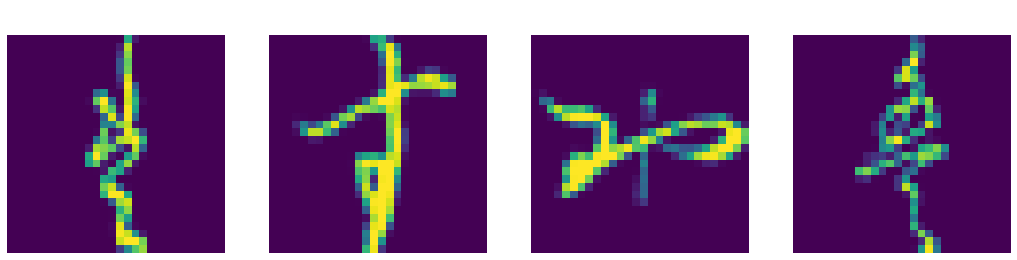

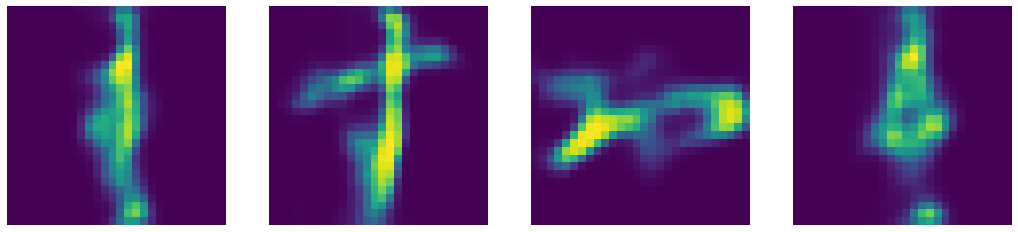

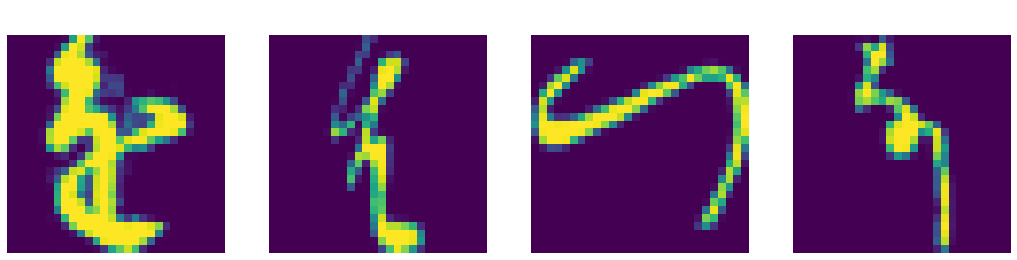

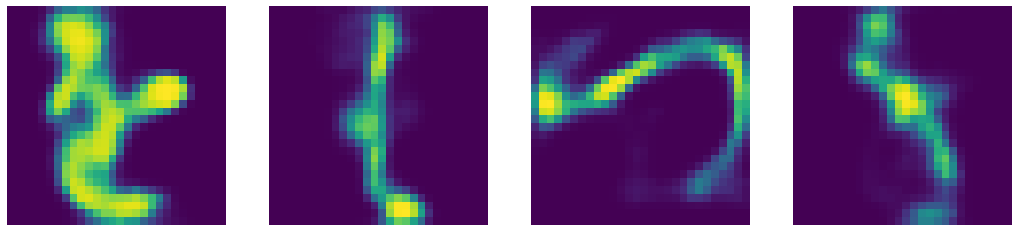

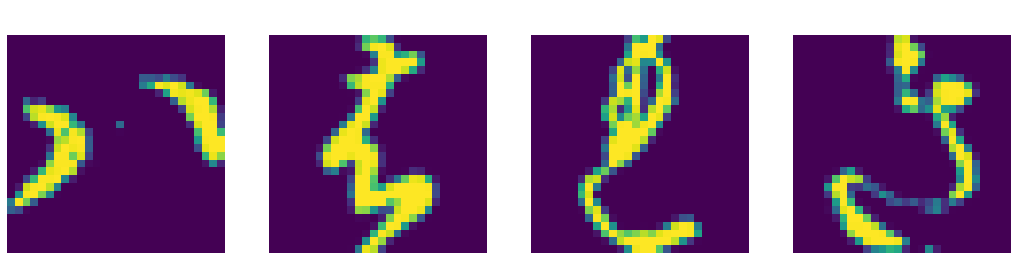

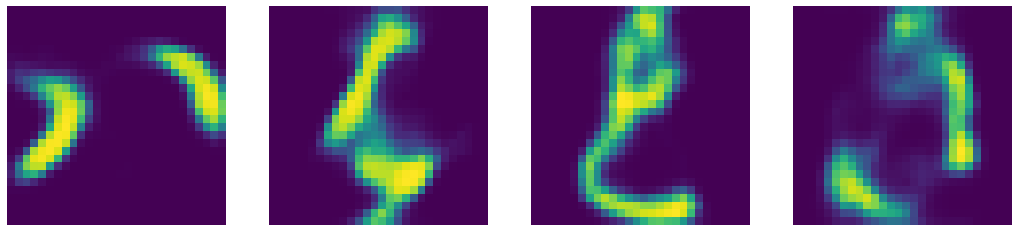

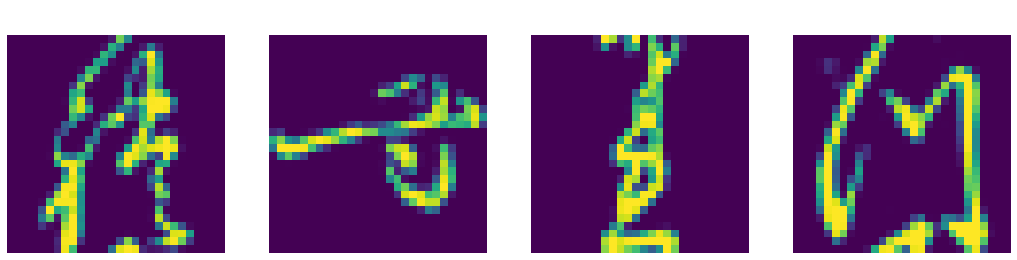

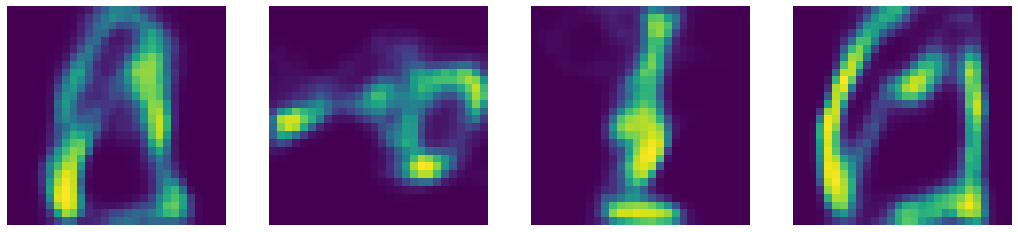

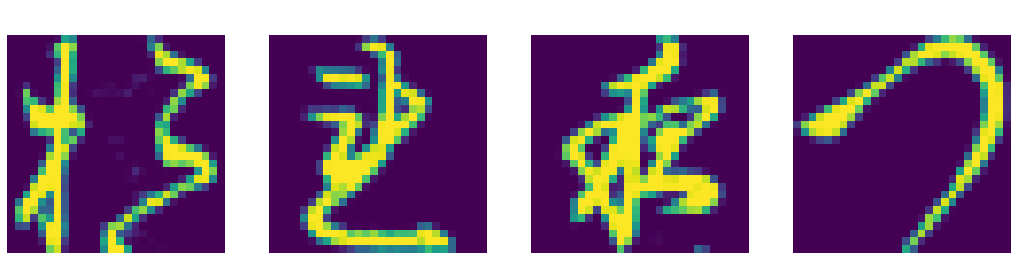

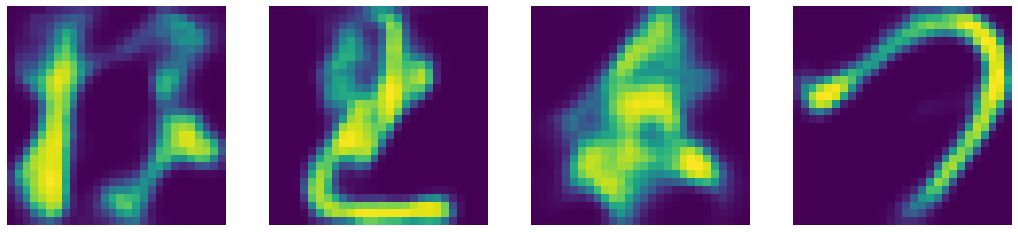

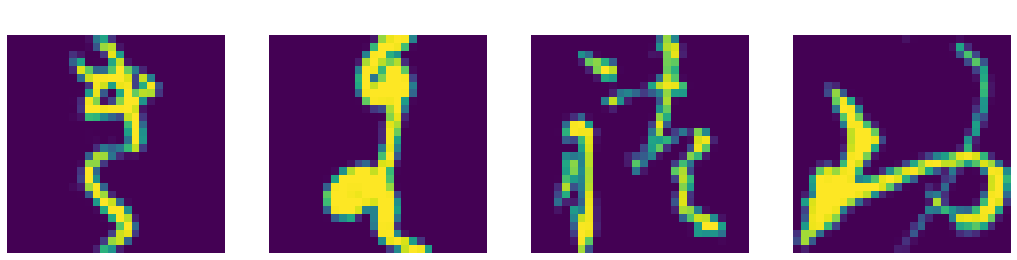

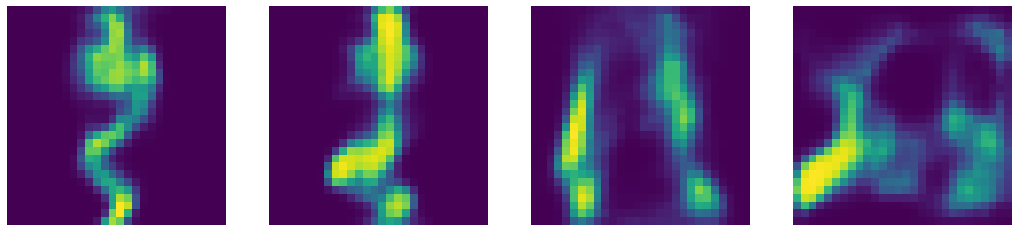

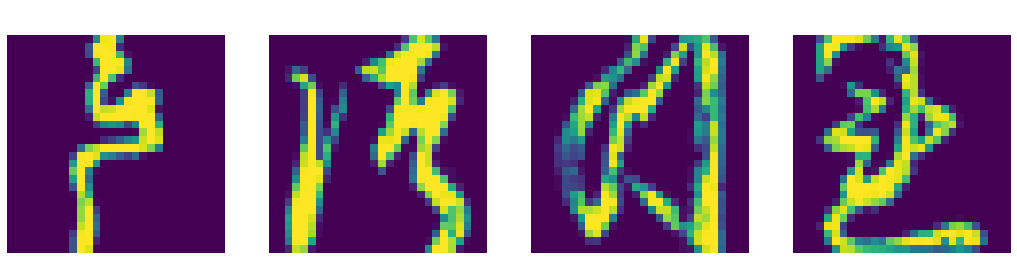

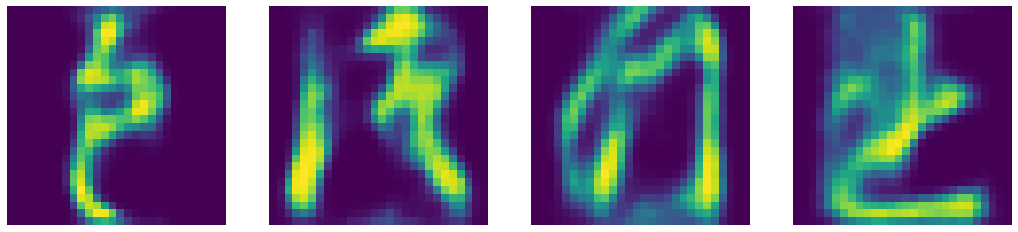

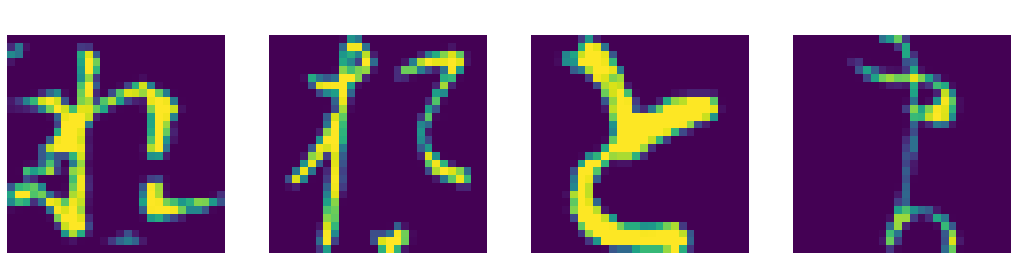

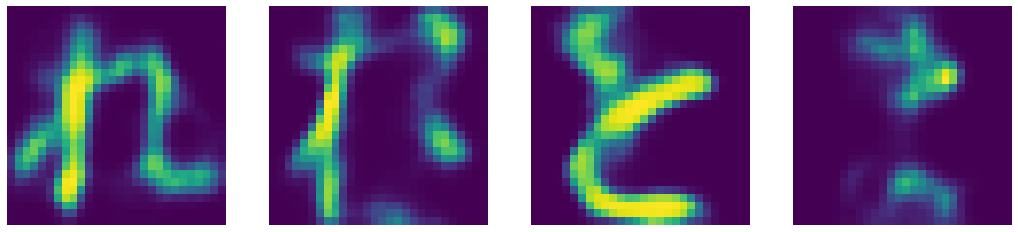

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Setting the optimiser

learning_rate = 1e-3
model = VAE().to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True}

codes = execute(epochs = 15,
        train_loader = torch.utils.data.DataLoader(
                        KMNIST('./data', train=True, download=True,
                        transform=transforms.ToTensor()),
                        batch_size=batch_size, shuffle=True, **kwargs),

        test_loader = torch.utils.data.DataLoader(
                      KMNIST('./data', train=False, transform=transforms.ToTensor()),
                      batch_size=batch_size, shuffle=True, **kwargs)
        )

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 3, 6,9,12,15)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(PCA(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

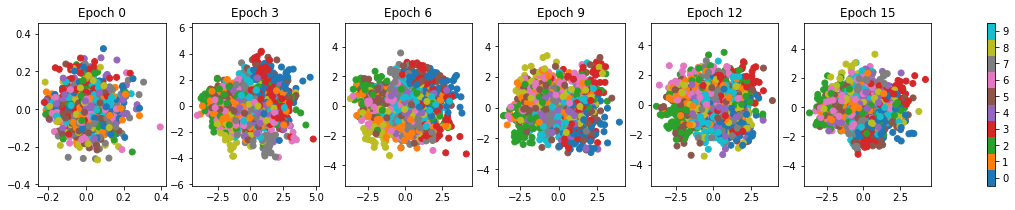

In [ ]:
f, a = plt.subplots(ncols=6,figsize=(20,3))
for i, e in enumerate(epochs):
    s = a[i].scatter(
        E[i][:,0],
        E[i][:,1],
        c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

Analisando o espaço latente, onde os pontos representam as figuras de grafia semelhante, podemos ver que embora os agrupamentos das classes aindam se misturem, de uma forma que elas não sejam claramente definidas no mapa, ao longo dessas gerações ainda temos a clara aproximação desses pontos. Portanto, ajustaremos alguns dos parâmetros, dentre eles o número de gerações e a taxa de aprendizado para que esse comportamento possa ser estendido.

##Simulacao 2

====> Test set loss: 544.8239
====> Epoch: 1 Average loss: 274.7098
====> Test set loss: 230.4909
====> Epoch: 2 Average loss: 223.9478
====> Test set loss: 219.6306
====> Epoch: 3 Average loss: 216.1714
====> Test set loss: 215.8707
====> Epoch: 4 Average loss: 212.5781
====> Test set loss: 212.8389
====> Epoch: 5 Average loss: 210.2030
====> Test set loss: 210.8100
====> Epoch: 6 Average loss: 208.5476
====> Test set loss: 210.4366
====> Epoch: 7 Average loss: 207.3482
====> Test set loss: 209.2626
====> Epoch: 8 Average loss: 206.3380
====> Test set loss: 208.2874
====> Epoch: 9 Average loss: 205.5748
====> Test set loss: 207.9260
====> Epoch: 10 Average loss: 204.8321
====> Test set loss: 207.4421


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


====> Epoch: 11 Average loss: 204.2902
====> Test set loss: 206.3356
====> Epoch: 12 Average loss: 203.6900
====> Test set loss: 206.2780
====> Epoch: 13 Average loss: 203.2927
====> Test set loss: 206.1674
====> Epoch: 14 Average loss: 202.8506
====> Test set loss: 206.6486
====> Epoch: 15 Average loss: 202.5129
====> Test set loss: 205.4622
====> Epoch: 16 Average loss: 202.1932
====> Test set loss: 205.1609
====> Epoch: 17 Average loss: 201.8796
====> Test set loss: 205.6659
====> Epoch: 18 Average loss: 201.5242
====> Test set loss: 204.4611
====> Epoch: 19 Average loss: 201.2859
====> Test set loss: 204.7064
====> Epoch: 20 Average loss: 201.1041
====> Test set loss: 204.9804
====> Epoch: 21 Average loss: 200.7949
====> Test set loss: 203.6089
====> Epoch: 22 Average loss: 200.6035
====> Test set loss: 204.4332
====> Epoch: 23 Average loss: 200.4360
====> Test set loss: 204.8023
====> Epoch: 24 Average loss: 200.2103
====> Test set loss: 204.1222
====> Epoch: 25 Average loss: 200.

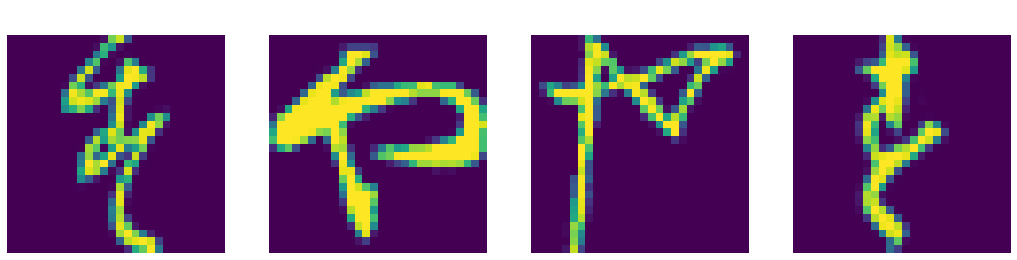

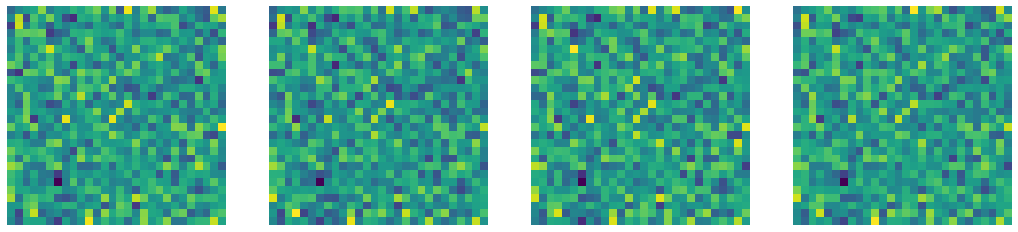

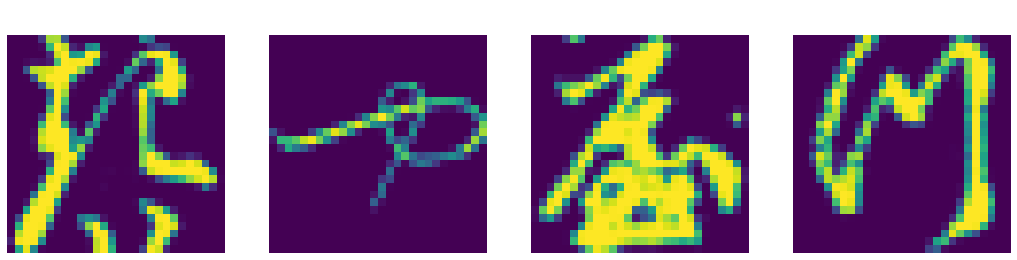

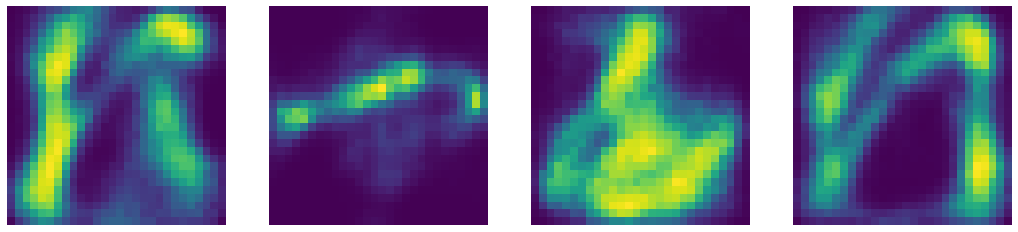

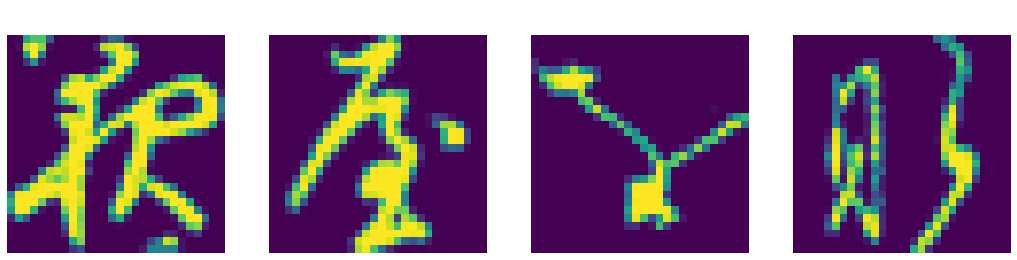

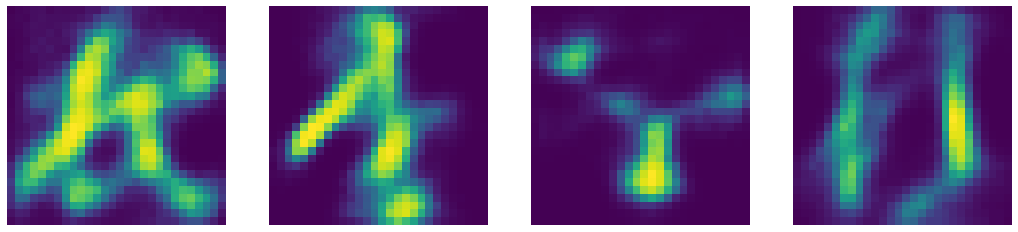

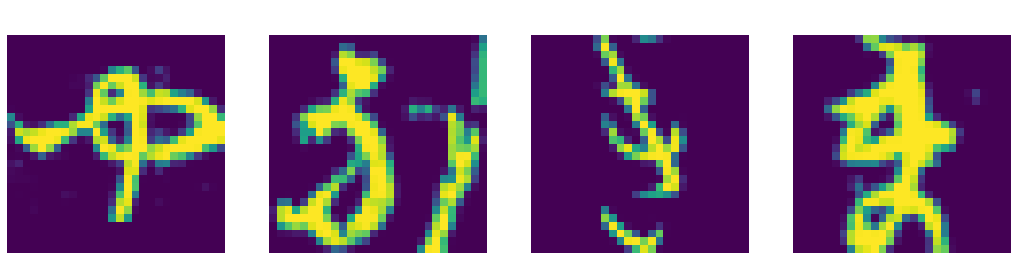

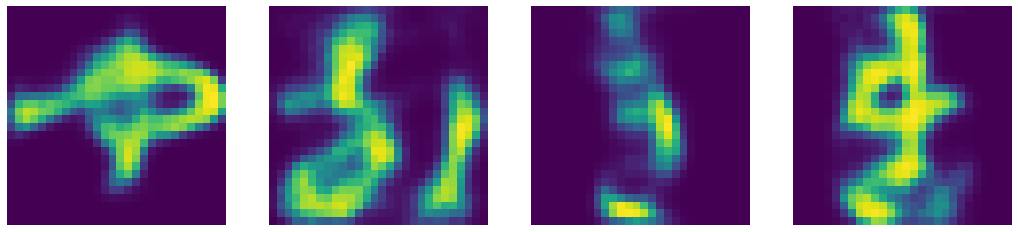

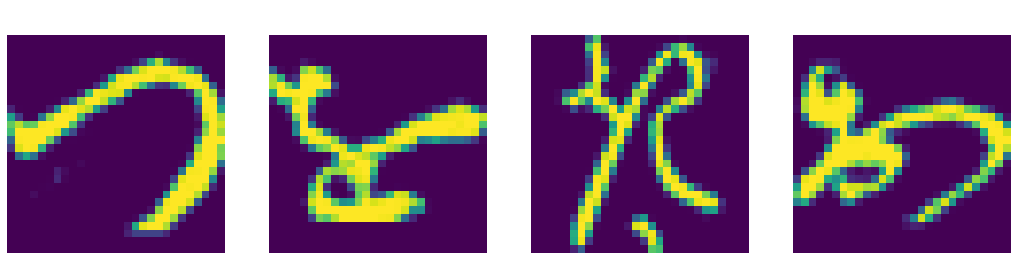

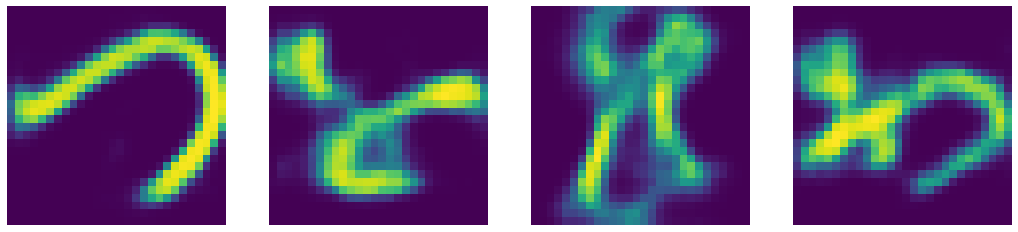

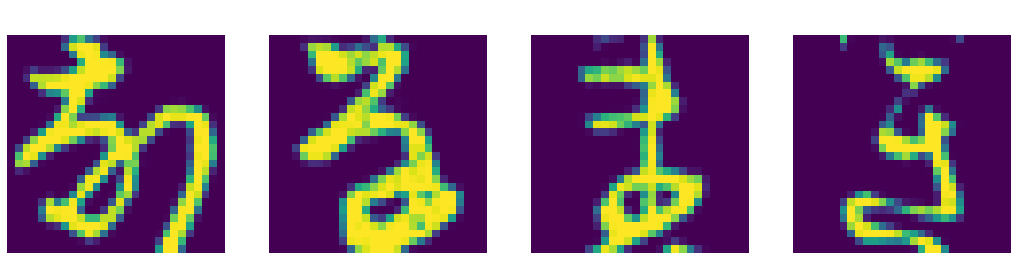

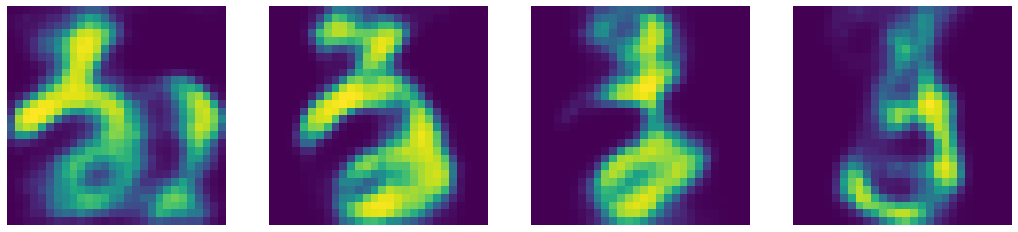

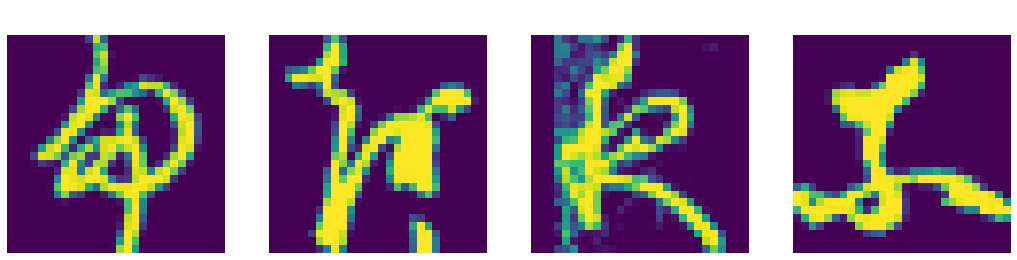

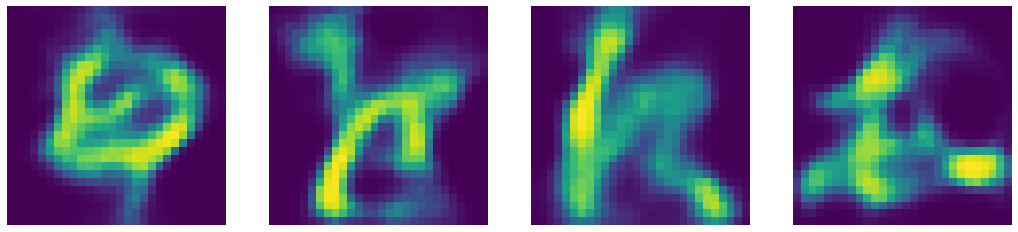

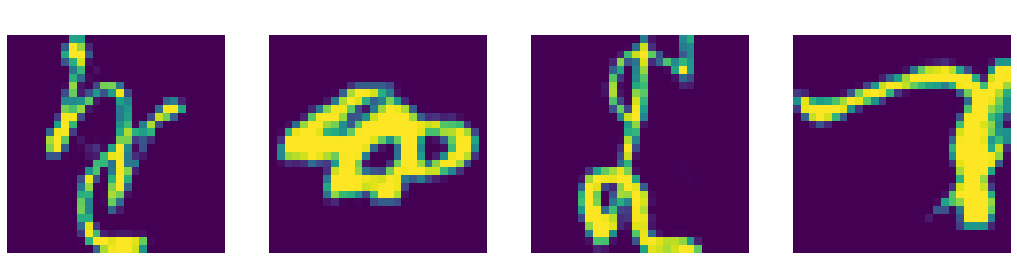

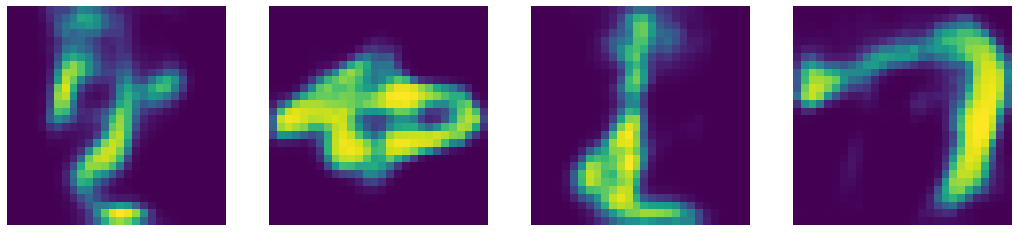

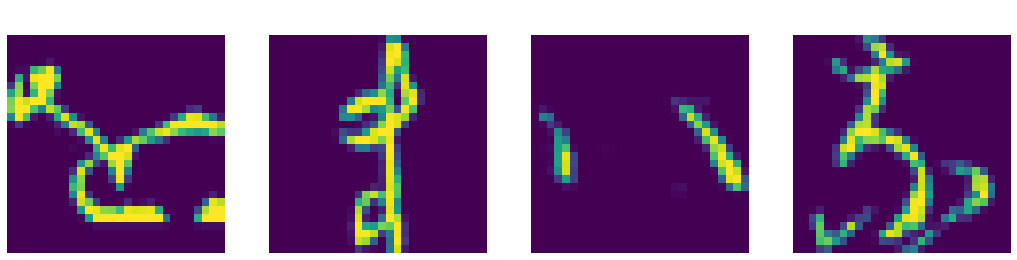

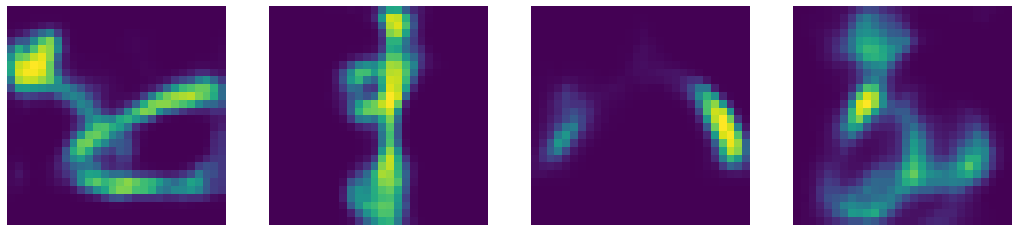

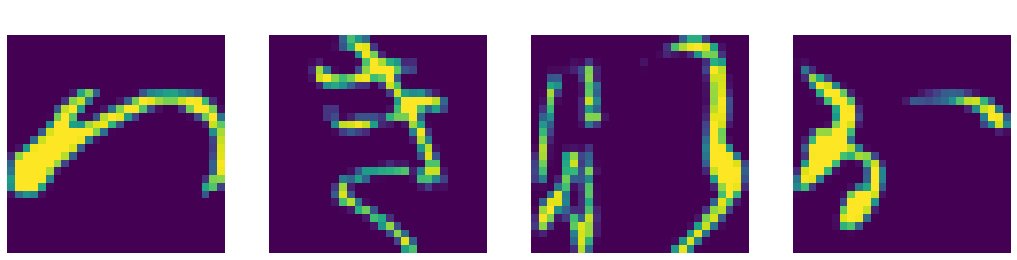

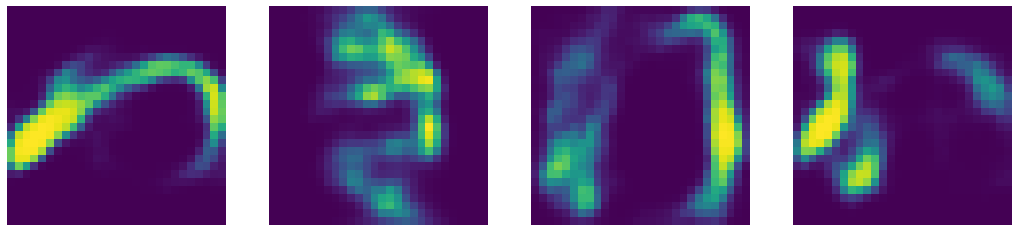

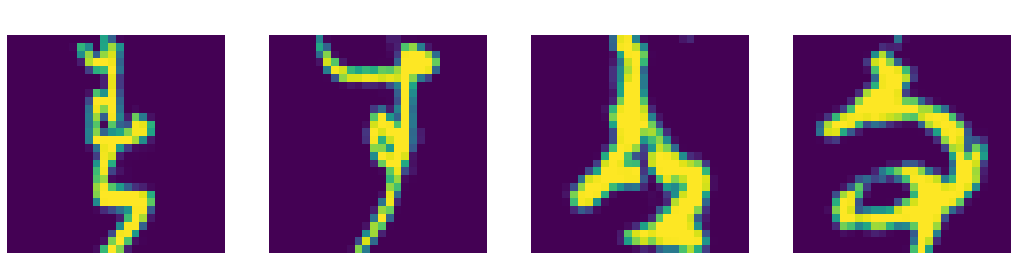

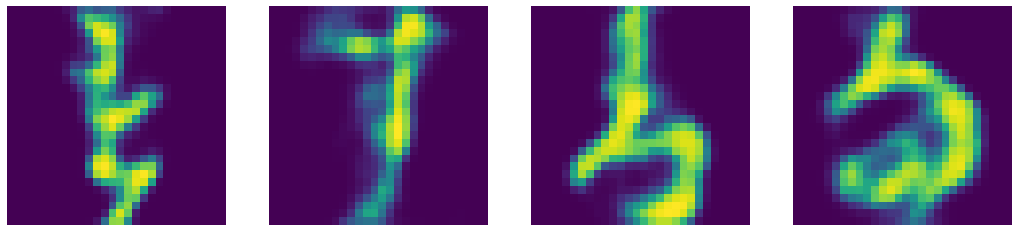

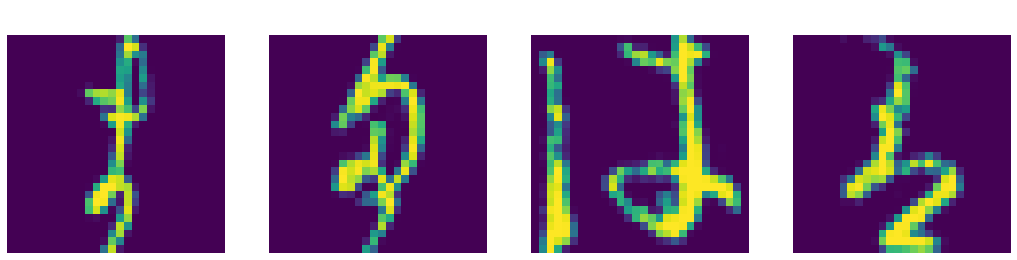

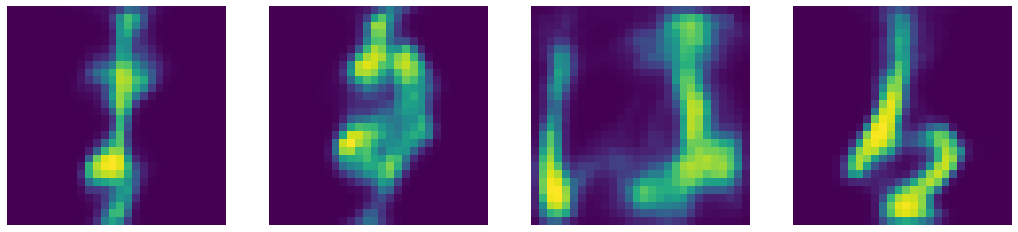

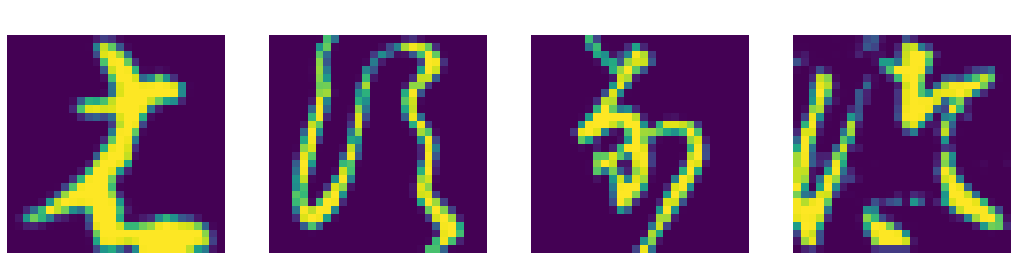

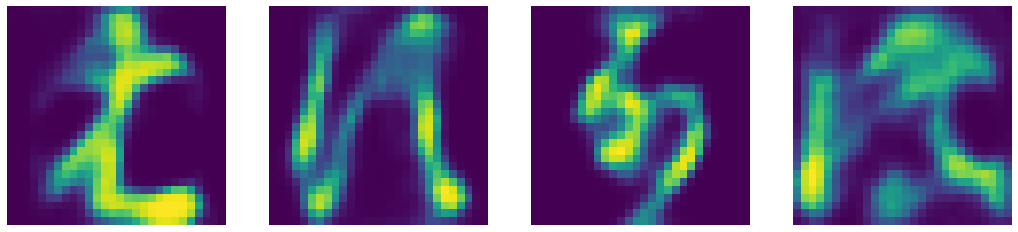

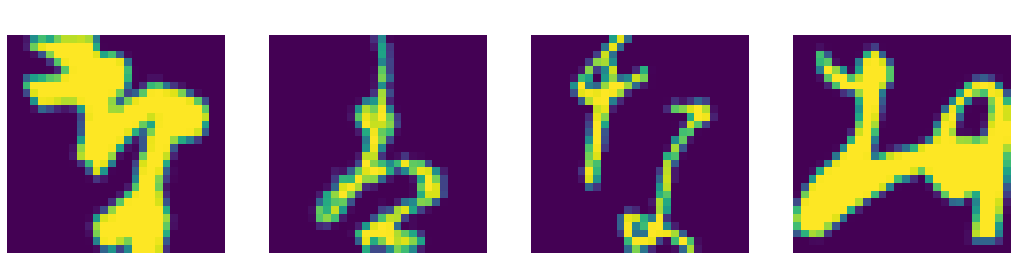

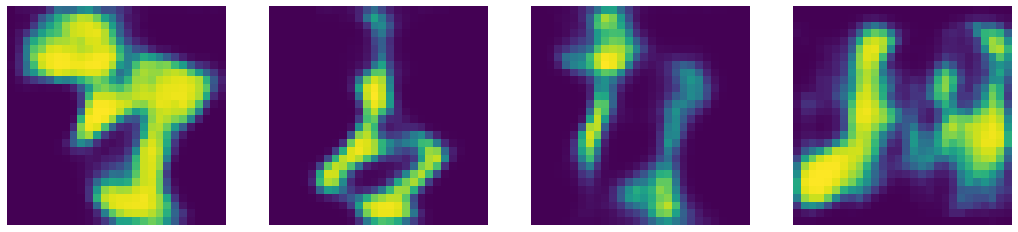

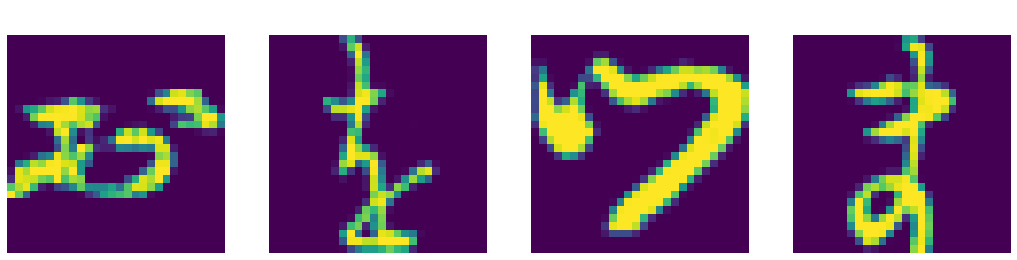

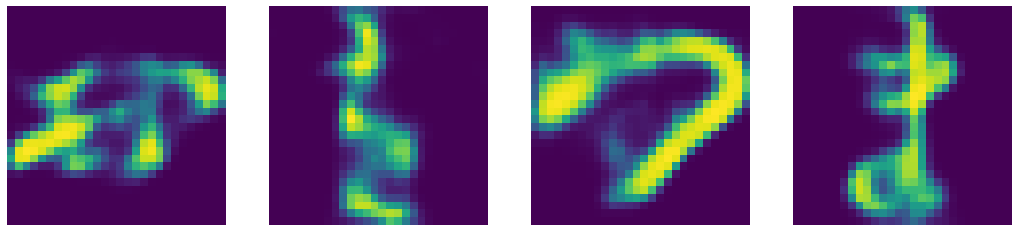

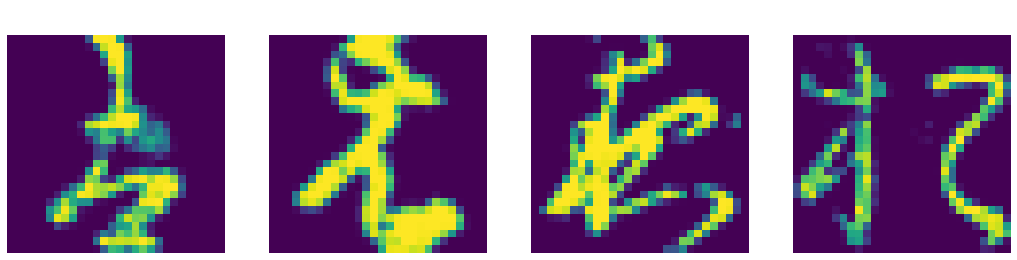

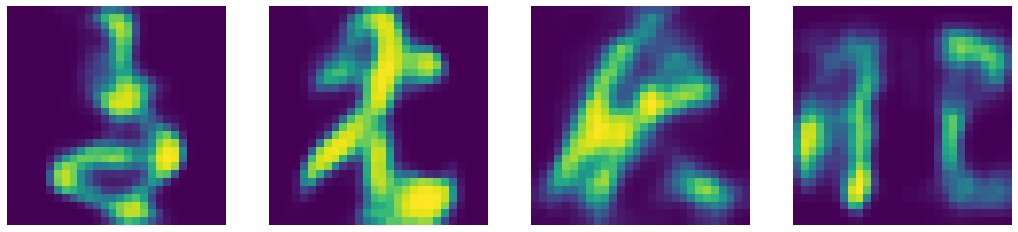

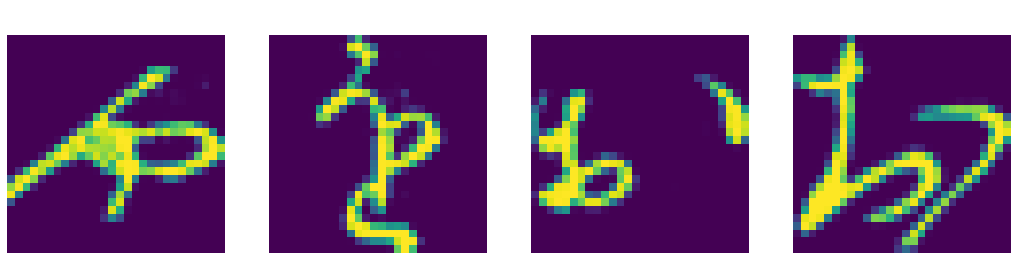

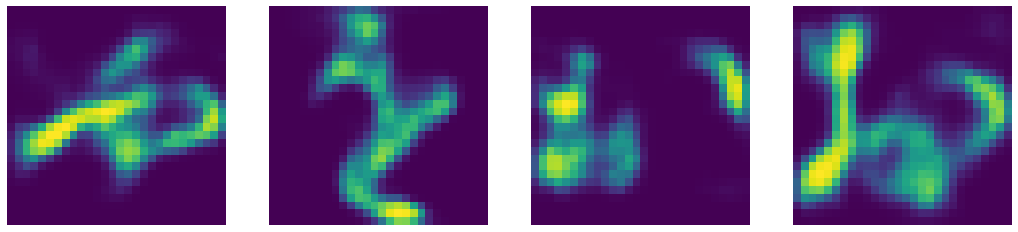

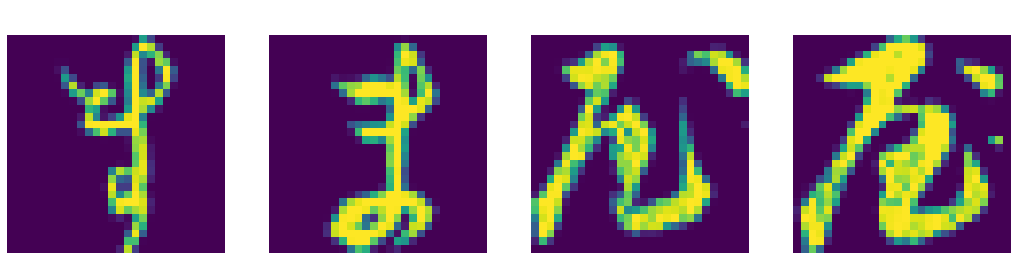

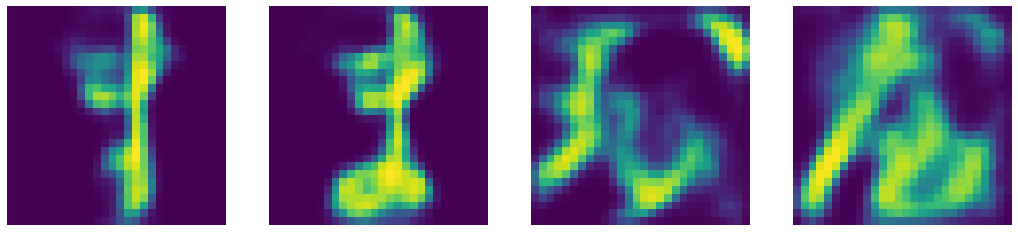

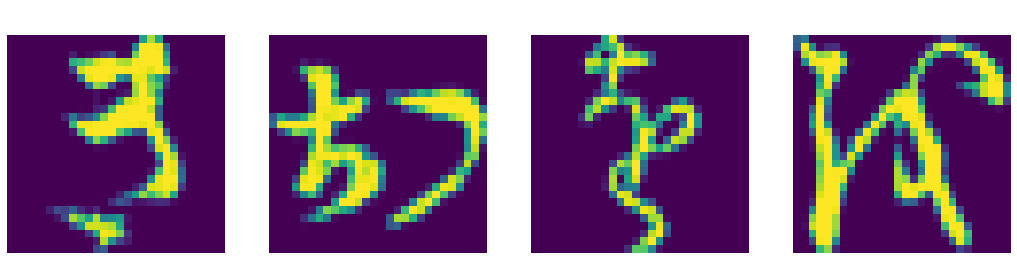

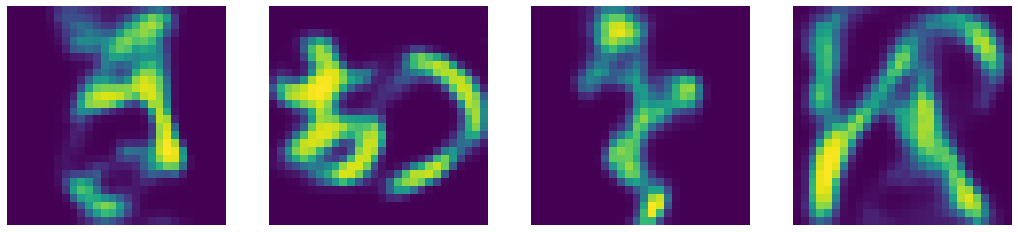

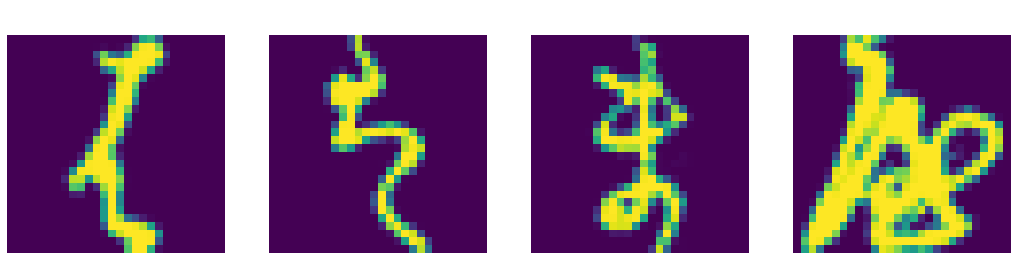

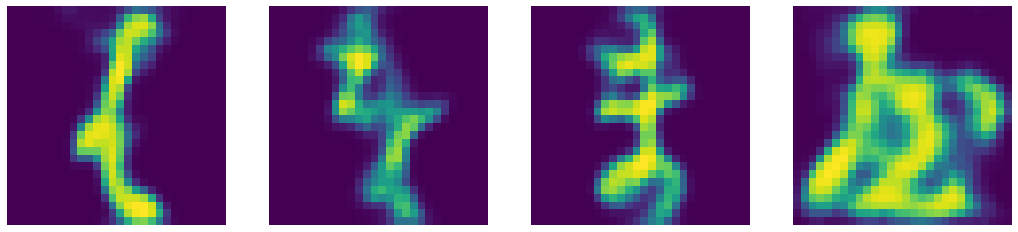

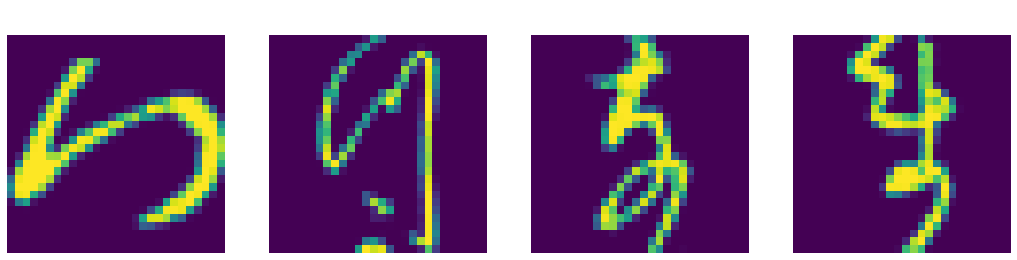

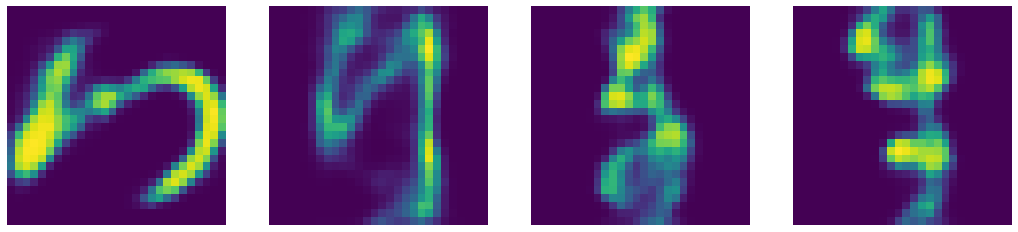

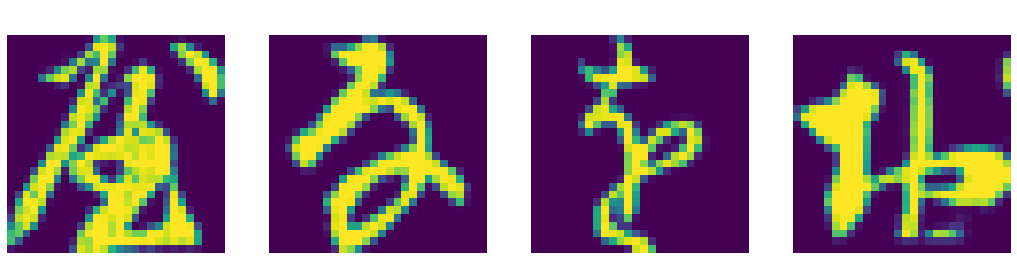

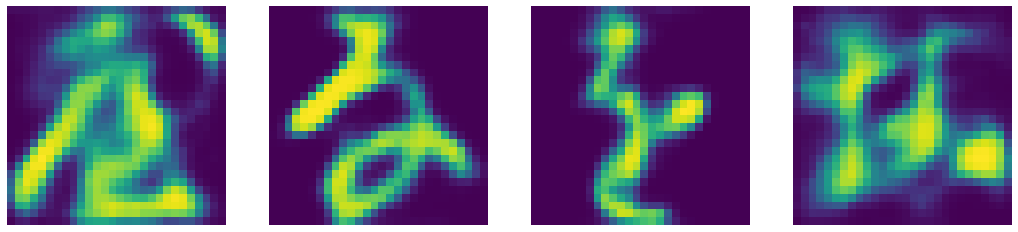

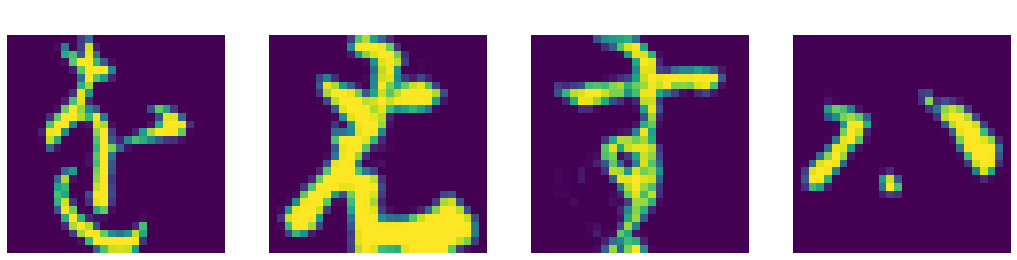

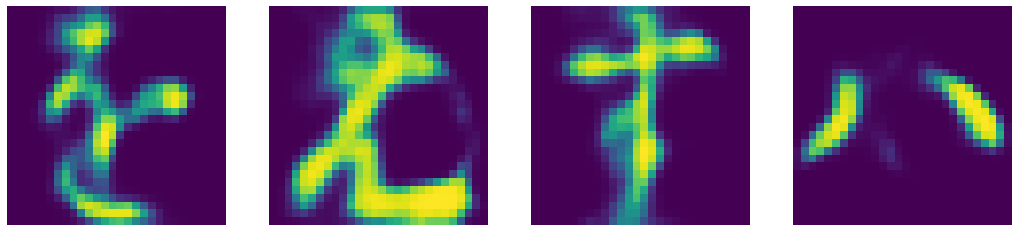

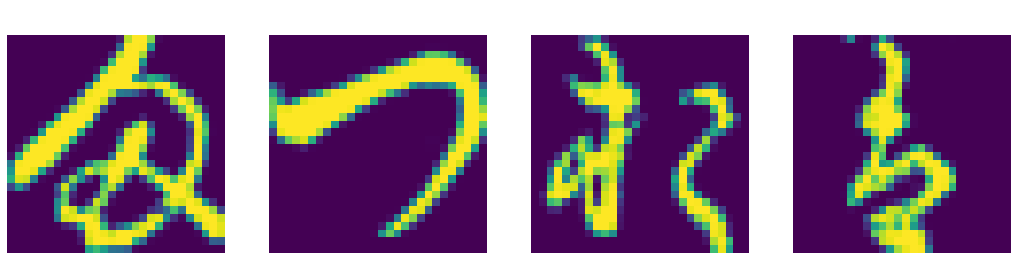

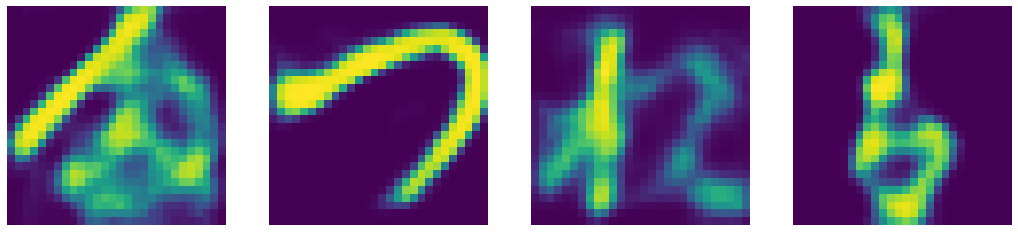

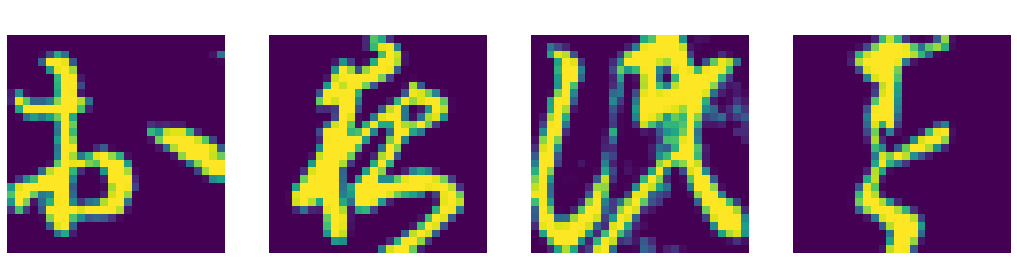

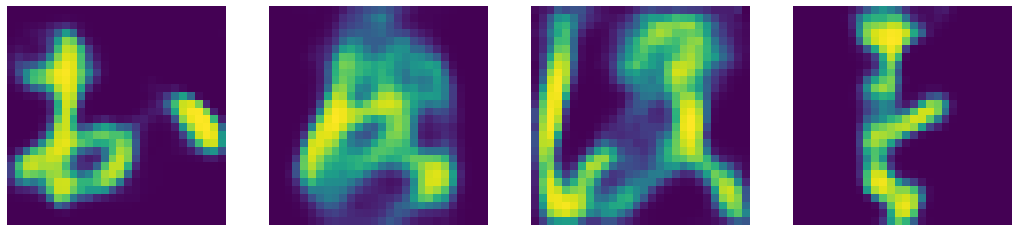

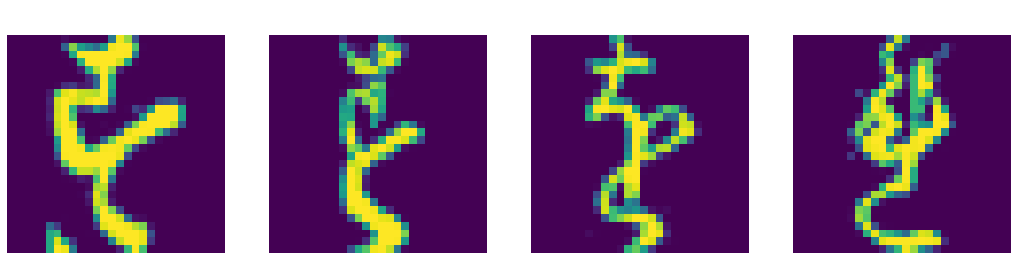

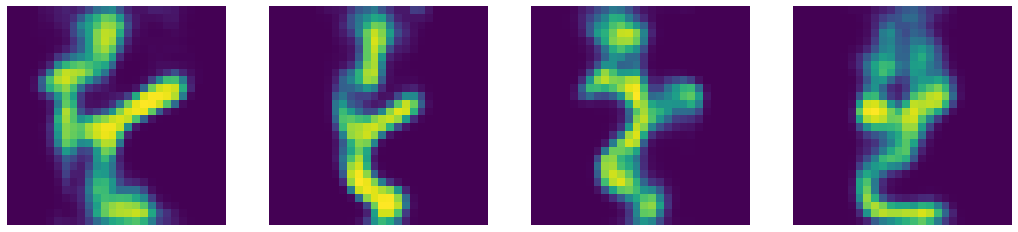

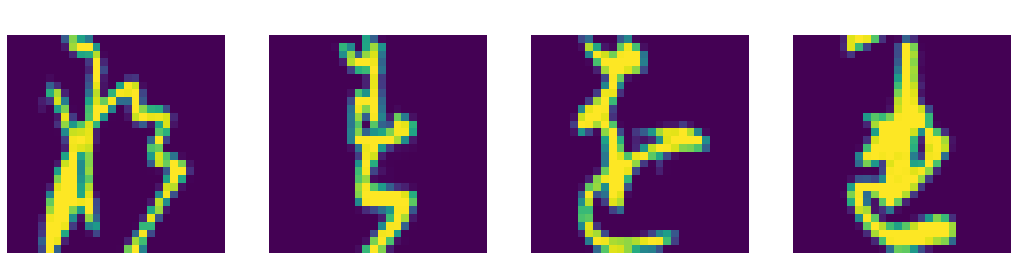

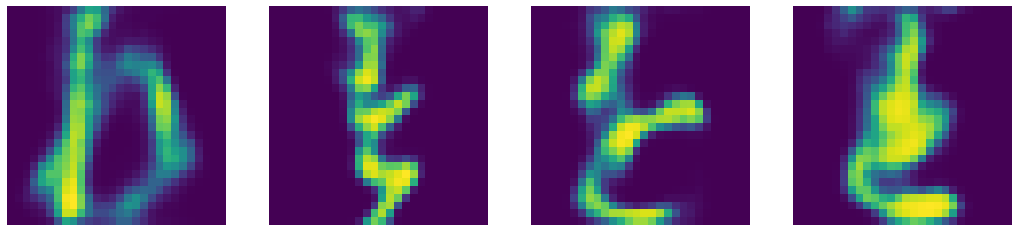

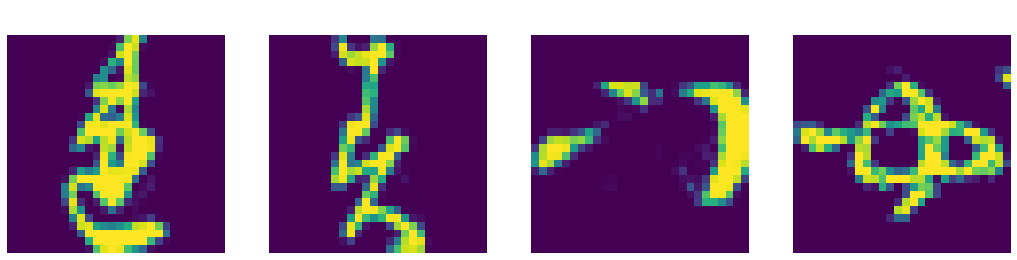

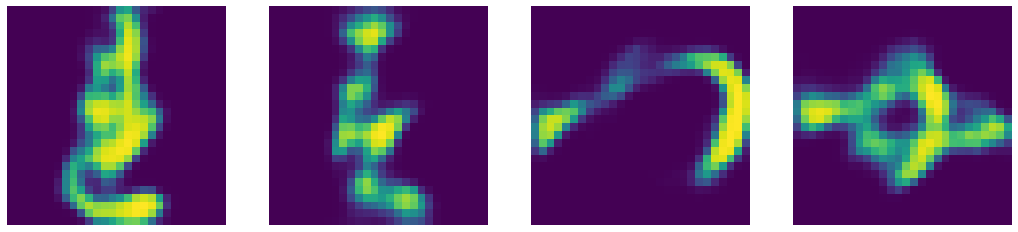

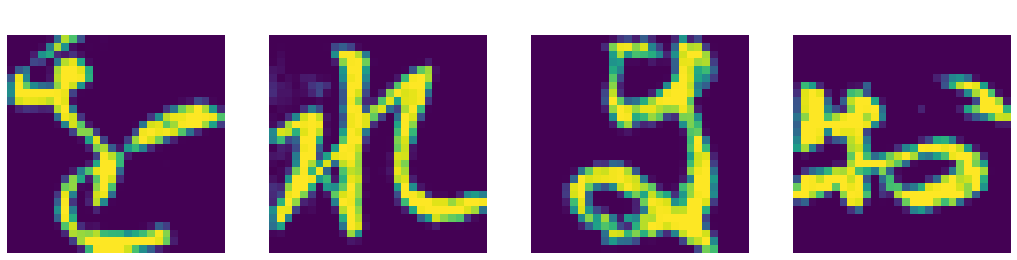

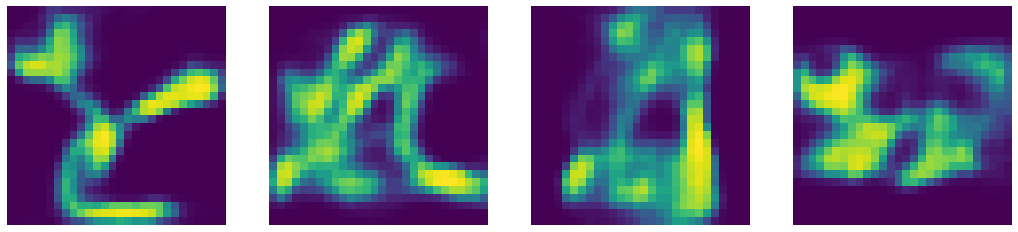

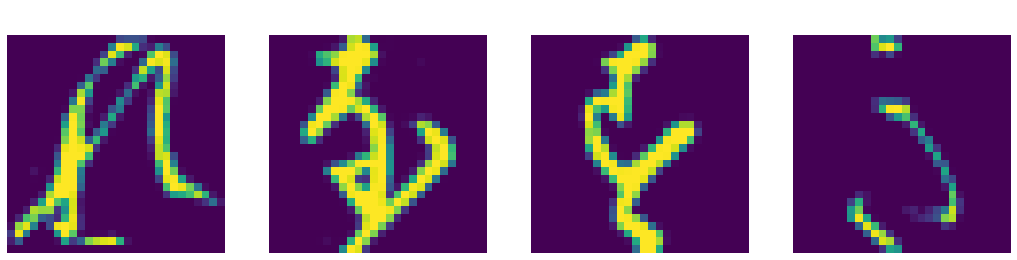

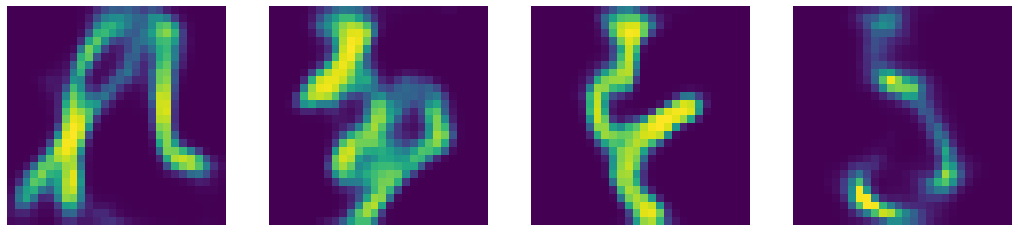

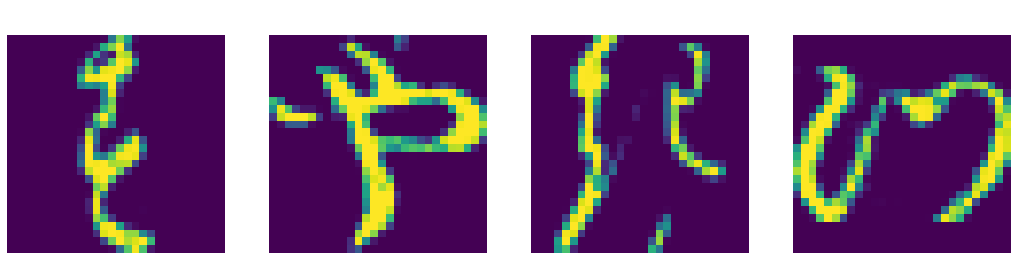

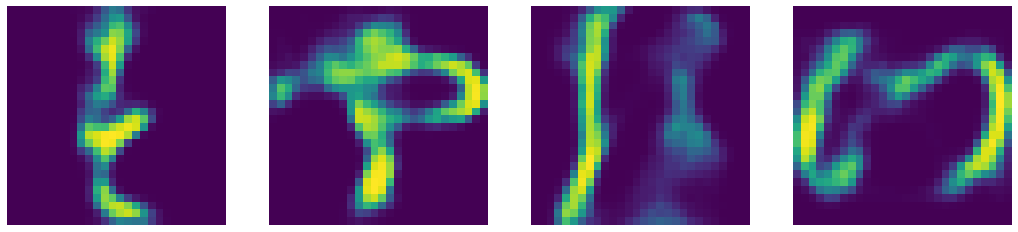

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Setting the optimiser

learning_rate = 1e-2
model = VAE(30).to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True}

codes = execute(epochs = 30,
        train_loader = torch.utils.data.DataLoader(
                        KMNIST('./data', train=True, download=True,
                        transform=transforms.ToTensor()),
                        batch_size=batch_size, shuffle=True, **kwargs),

        test_loader = torch.utils.data.DataLoader(
                      KMNIST('./data', train=False, transform=transforms.ToTensor()),
                      batch_size=batch_size, shuffle=True, **kwargs)
        )

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10,15,20,25,30)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(PCA(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

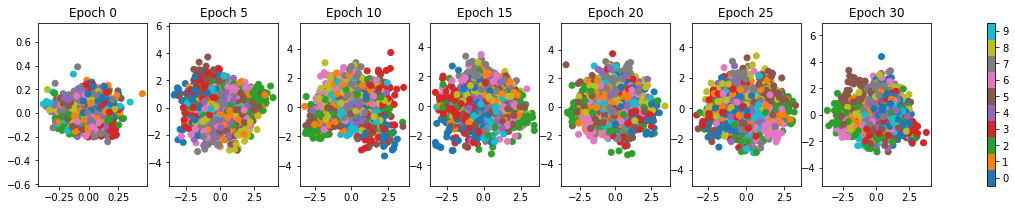

In [ ]:
f, a = plt.subplots(ncols=7,figsize=(20,3))
for i, e in enumerate(epochs):
    s = a[i].scatter(
        E[i][:,0],
        E[i][:,1],
        c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

<p>
Podemos ver que com as modificações feitas, algumas das mudanças esperadas surgiram, como a maior definição dos agrupamentos da maioria das classes. Porém, podemos ver que alguns pontos isolados ainda estão dispersos, e as classses continuam se definindo relativamente bem entre si, mas o comportamento de classes diferentes próximas ainda continua
</p>

#EMINST

<p>
Já no segundo dataset, temos a seguinte amostra das entradas
</p>

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


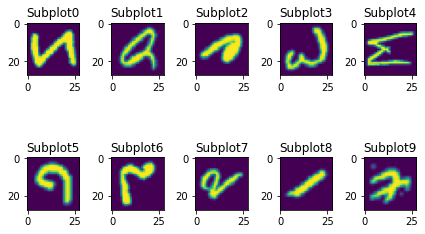

In [ ]:
inputSet = datasets.EMNIST('./data/', download=True, train=True,split='byclass', transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))]))
fig=plt.figure()
axes = []
for a in range(10):
    axes.append( fig.add_subplot(2, 5, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)
    plt.imshow(inputSet.data[a])

fig.tight_layout()
plt.show()

##Simulaçao 3

====> Test set loss: 544.1287
====> Epoch: 1 Average loss: 158.0140
====> Test set loss: 140.1905
====> Epoch: 2 Average loss: 148.1998
====> Test set loss: 138.2875
====> Epoch: 3 Average loss: 146.8080
====> Test set loss: 137.8370
====> Epoch: 4 Average loss: 146.0119
====> Test set loss: 136.8926
====> Epoch: 5 Average loss: 145.4952
====> Test set loss: 136.4992
====> Epoch: 6 Average loss: 145.1636
====> Test set loss: 136.7125
====> Epoch: 7 Average loss: 144.8979
====> Test set loss: 136.0140
====> Epoch: 8 Average loss: 144.7107
====> Test set loss: 136.1745
====> Epoch: 9 Average loss: 144.5637
====> Test set loss: 135.0758
====> Epoch: 10 Average loss: 144.4269
====> Test set loss: 136.1992


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure

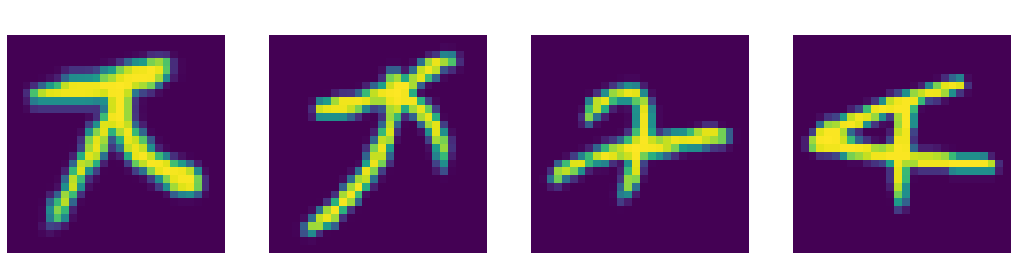

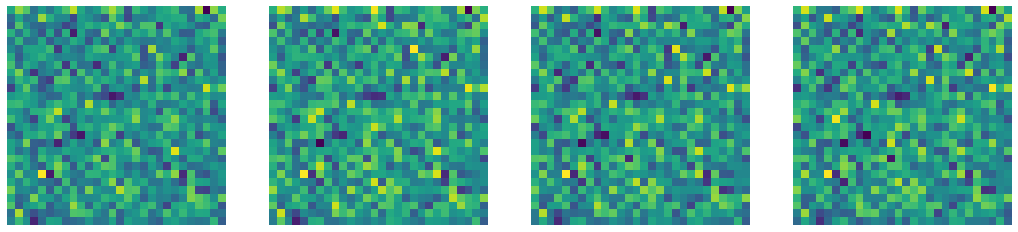

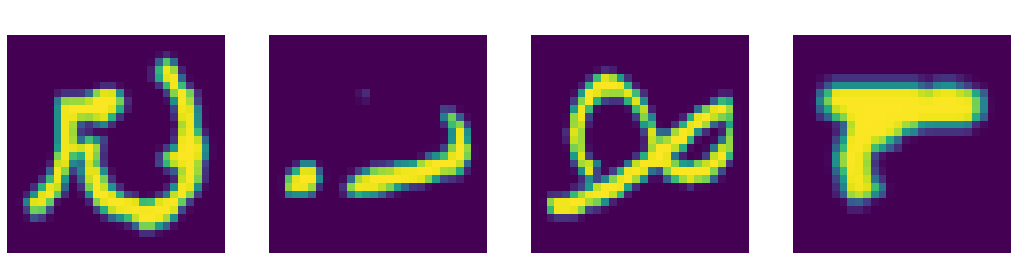

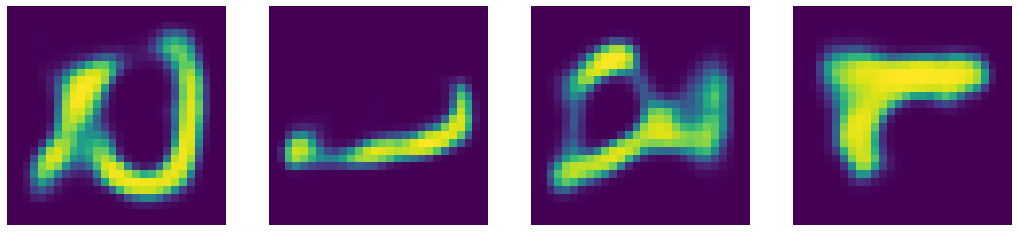

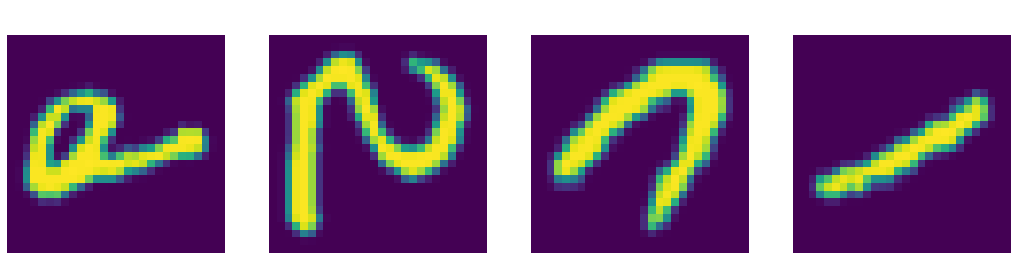

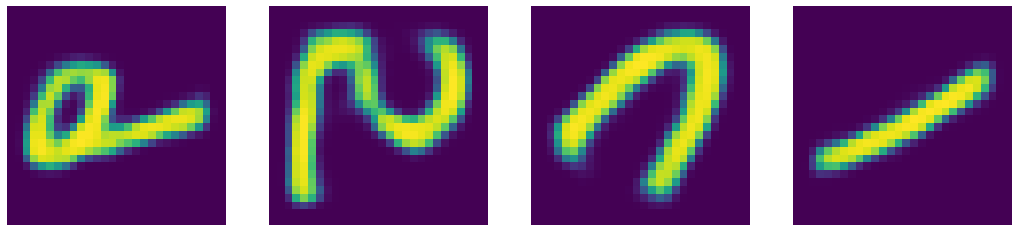

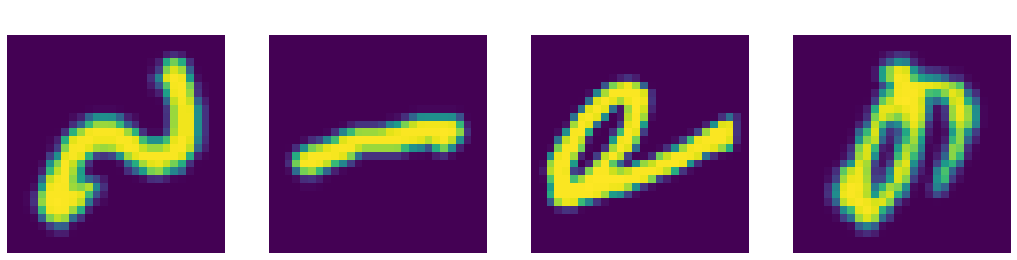

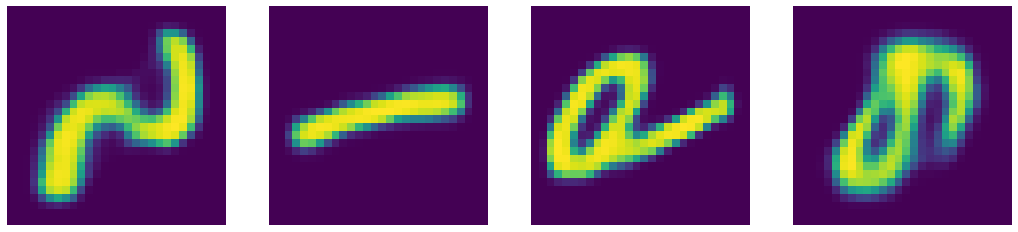

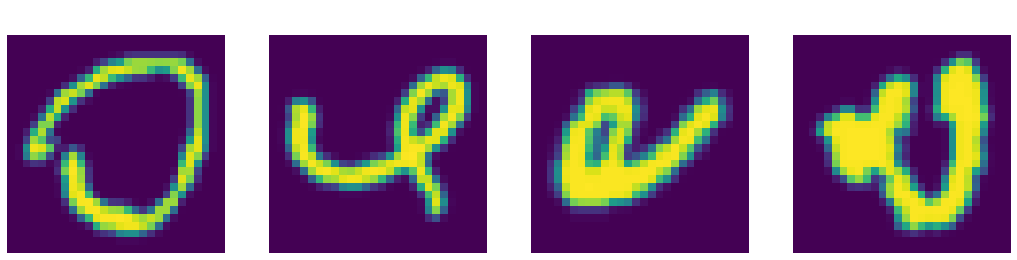

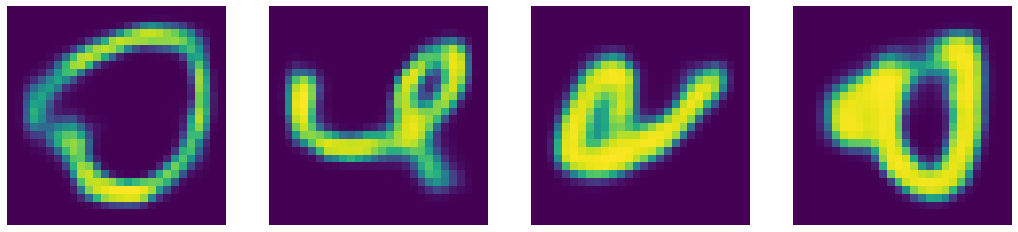

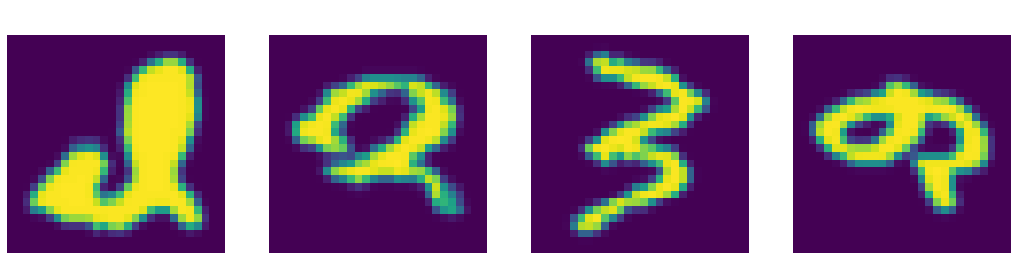

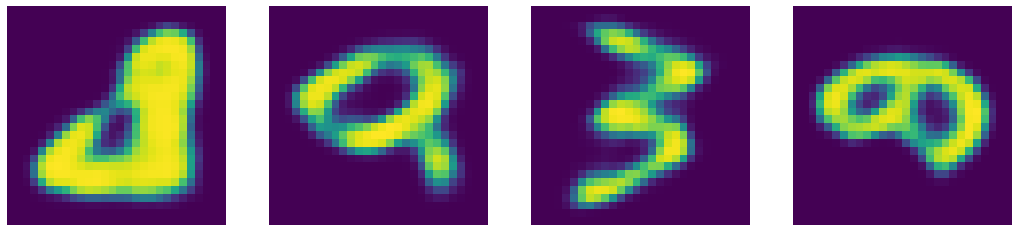

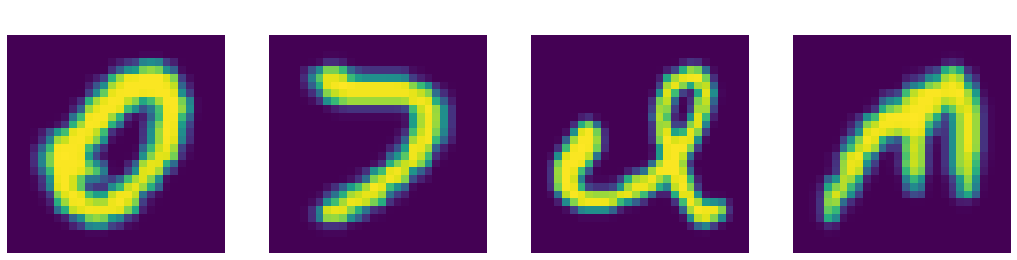

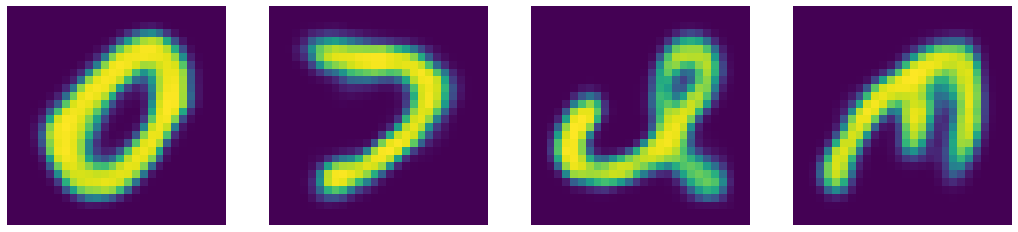

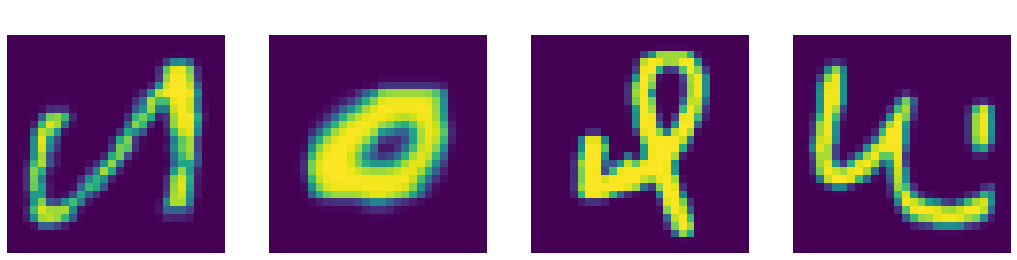

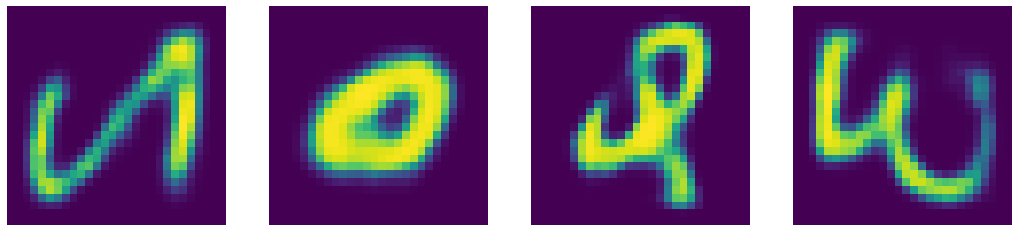

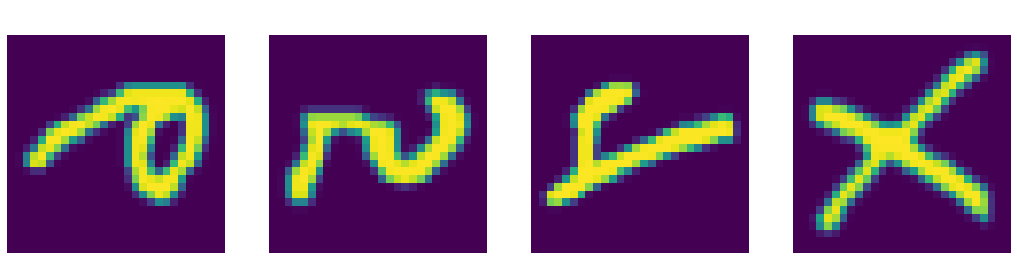

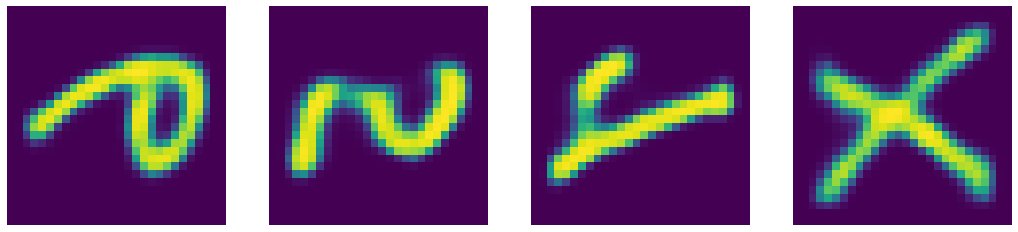

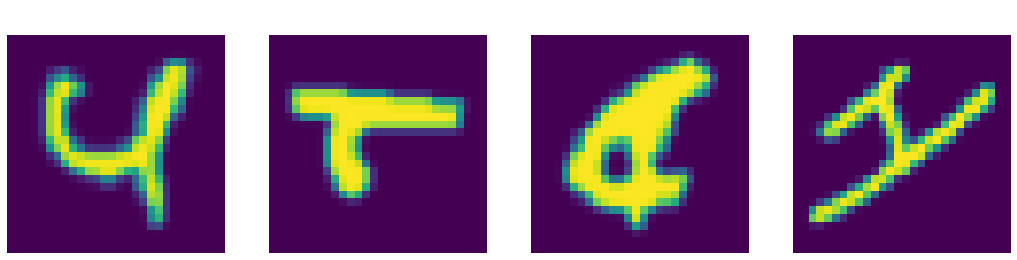

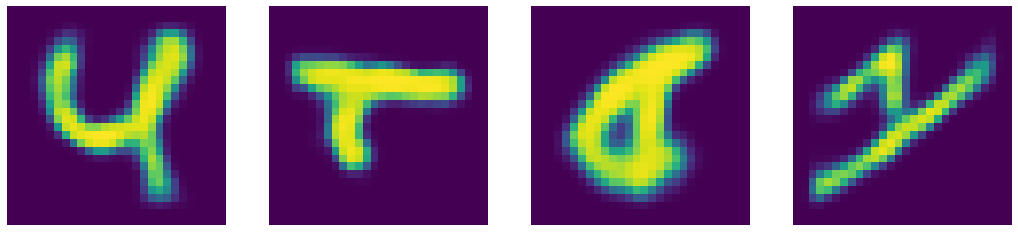

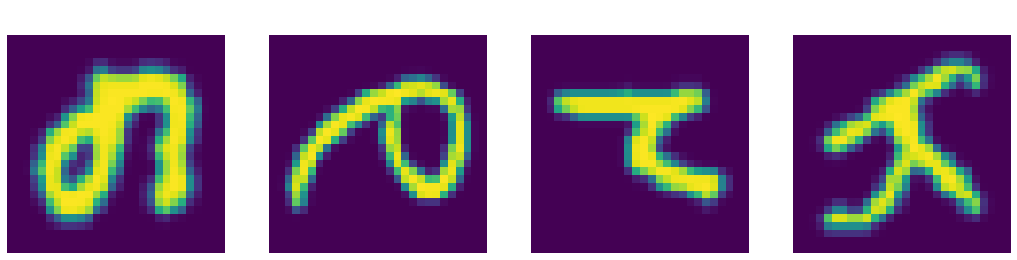

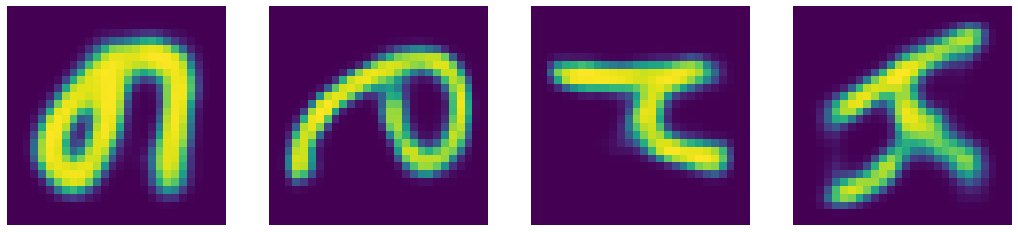

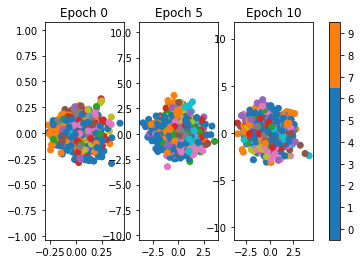

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Setting the optimiser

learning_rate = 1e-3
model = VAE().to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True}
codes = execute(epochs = 10,
        train_loader = torch.utils.data.DataLoader(
                        EMNIST('./data', train=True, download=True, split='byclass',
                        transform=transforms.ToTensor()),
                        batch_size=batch_size, shuffle=True, **kwargs),

        test_loader = torch.utils.data.DataLoader(
                      EMNIST('./data', train=False,split='byclass', transform=transforms.ToTensor()),
                      batch_size=batch_size, shuffle=True, **kwargs)
        )


plot(codes)

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 2,4,6,8,10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(PCA(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

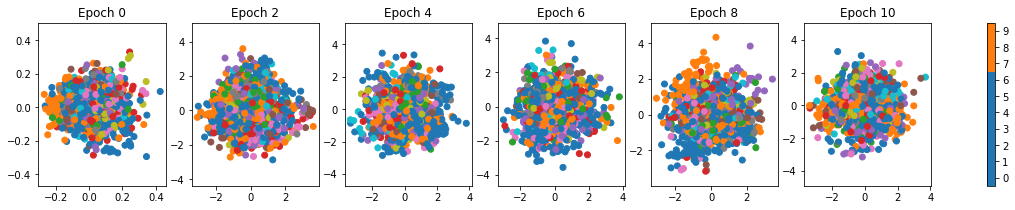

In [ ]:
f, a = plt.subplots(ncols=6,figsize=(20,3))
for i, e in enumerate(epochs):
    s = a[i].scatter(
        E[i][:,0],
        E[i][:,1],
        c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

<p>
Vemos que mesmo com o avanço das épocas, os clusters ainda não se definiram tão bem, tendo pontos dispersos de todas as classes ao longo do mapa. Note também que duas classes dominam a maior parte dos exemplos, que Tomaremos medidas parecidas a primeira simulação a fim de melhorar os resultados.
</p>

##Simulacao 4

====> Test set loss: 543.4155
====> Epoch: 1 Average loss: 163.5320
====> Test set loss: 142.0395
====> Epoch: 2 Average loss: 149.3642
====> Test set loss: 138.7734
====> Epoch: 3 Average loss: 147.5814
====> Test set loss: 138.7452
====> Epoch: 4 Average loss: 146.6302
====> Test set loss: 137.6808
====> Epoch: 5 Average loss: 146.0126
====> Test set loss: 136.4924
====> Epoch: 6 Average loss: 145.5955
====> Test set loss: 136.9492
====> Epoch: 7 Average loss: 145.2590
====> Test set loss: 136.2879
====> Epoch: 8 Average loss: 145.0066
====> Test set loss: 136.2606
====> Epoch: 9 Average loss: 144.7953
====> Test set loss: 135.7975
====> Epoch: 10 Average loss: 144.6191
====> Test set loss: 135.4925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


====> Epoch: 11 Average loss: 144.4768
====> Test set loss: 135.5110
====> Epoch: 12 Average loss: 144.3403
====> Test set loss: 136.0898
====> Epoch: 13 Average loss: 144.2274
====> Test set loss: 135.4366
====> Epoch: 14 Average loss: 144.1218
====> Test set loss: 135.8061
====> Epoch: 15 Average loss: 144.0398
====> Test set loss: 135.5833
====> Epoch: 16 Average loss: 143.9453
====> Test set loss: 136.0046
====> Epoch: 17 Average loss: 143.8911
====> Test set loss: 134.9823
====> Epoch: 18 Average loss: 143.8089
====> Test set loss: 134.7460
====> Epoch: 19 Average loss: 143.7581
====> Test set loss: 135.4162
====> Epoch: 20 Average loss: 143.6861
====> Test set loss: 134.7539
====> Epoch: 21 Average loss: 143.6400
====> Test set loss: 135.2971
====> Epoch: 22 Average loss: 143.5738
====> Test set loss: 134.8253
====> Epoch: 23 Average loss: 143.5414
====> Test set loss: 135.0812
====> Epoch: 24 Average loss: 143.4775
====> Test set loss: 135.2134
====> Epoch: 25 Average loss: 143.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


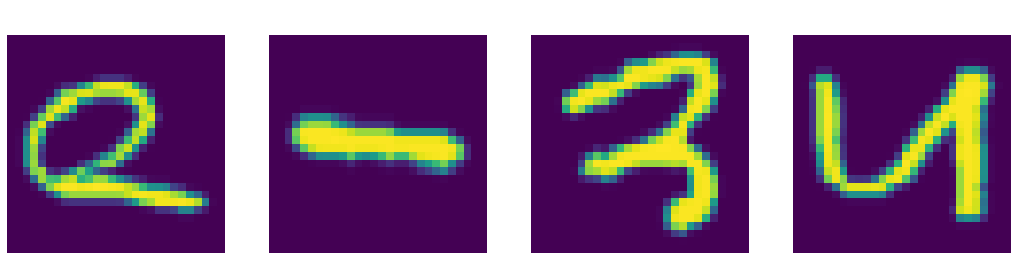

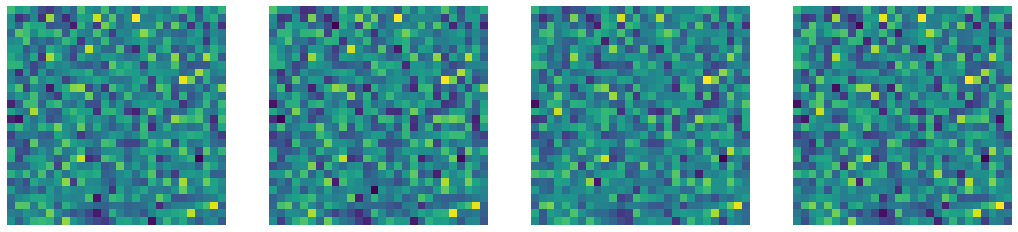

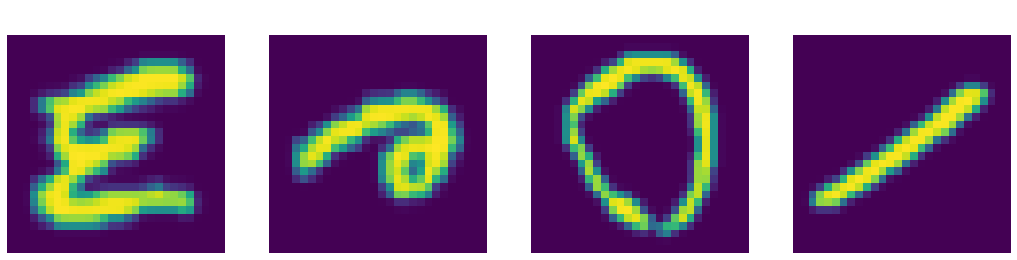

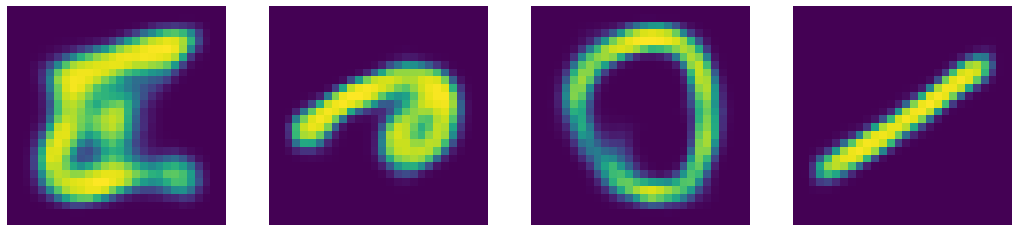

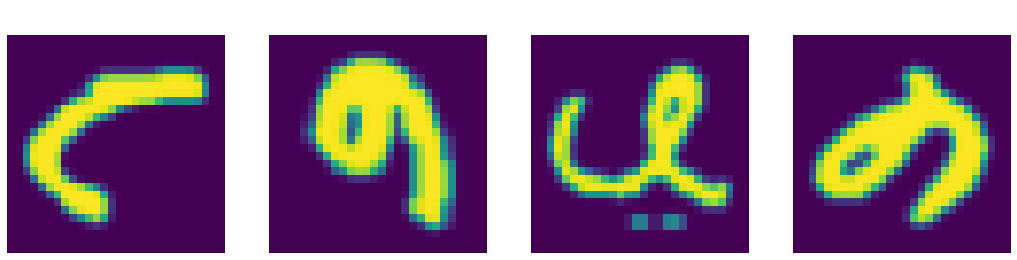

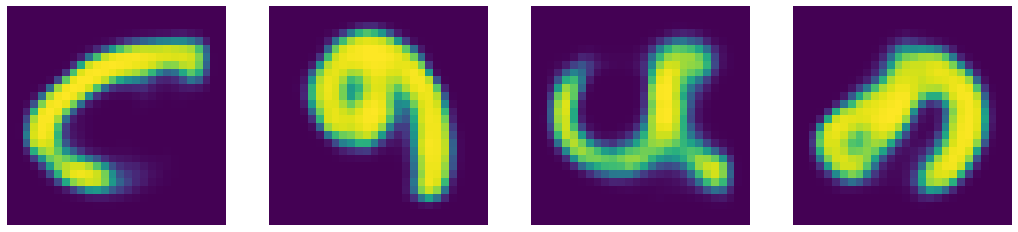

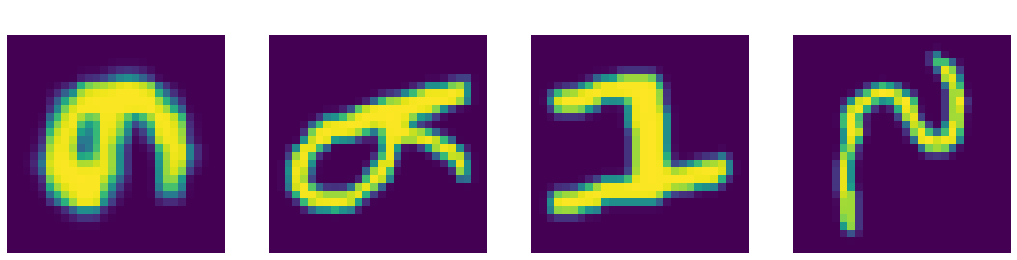

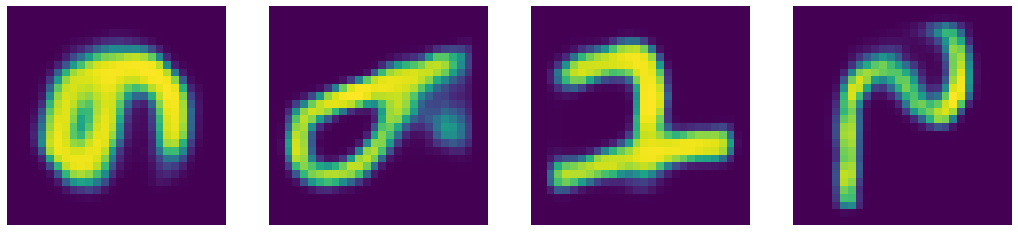

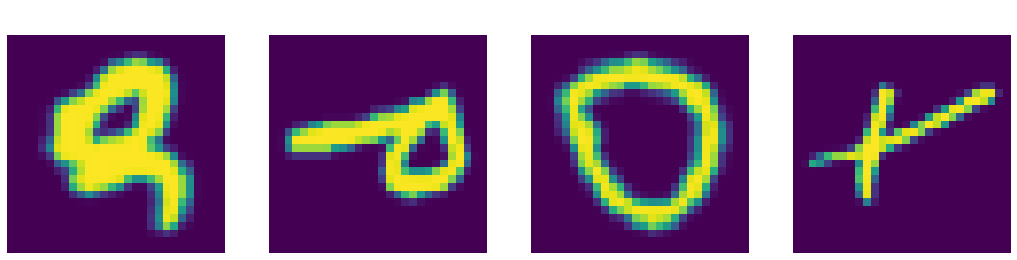

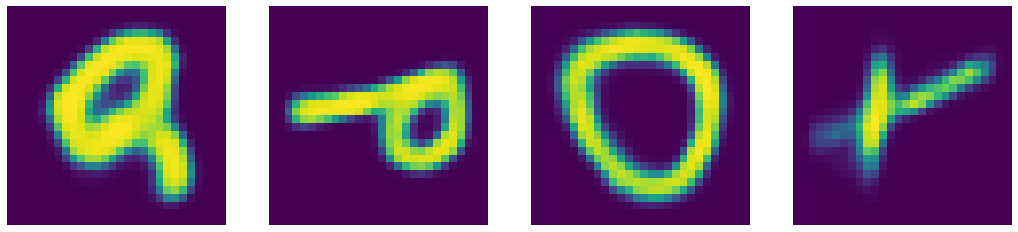

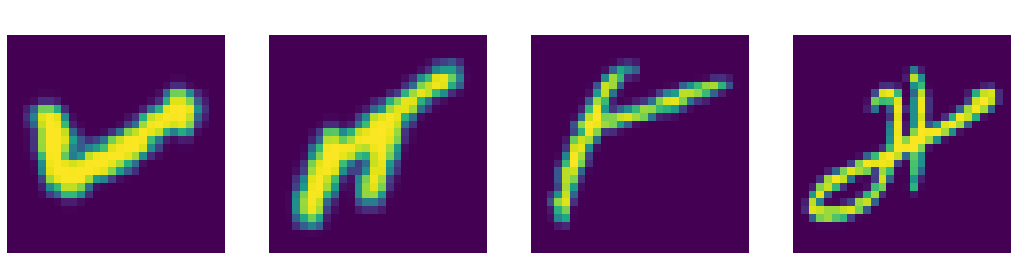

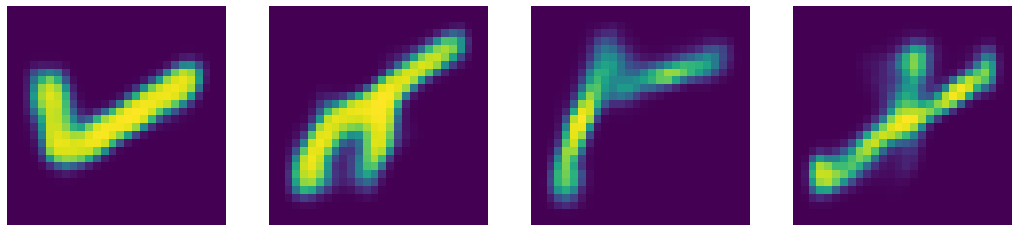

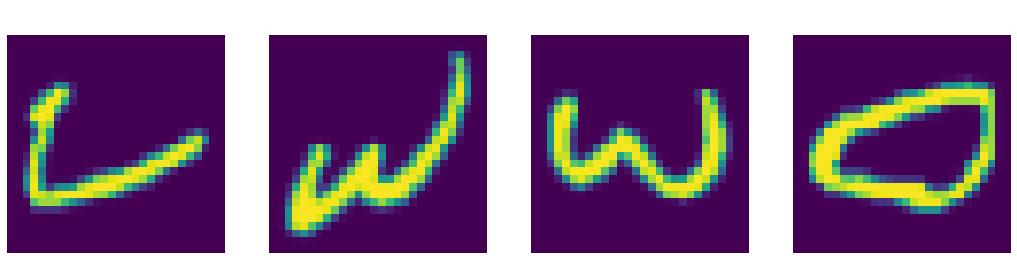

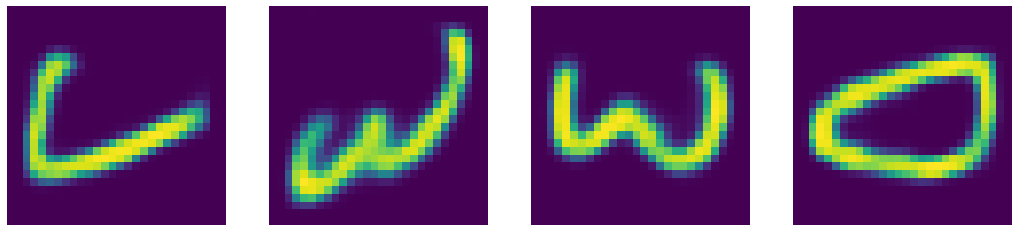

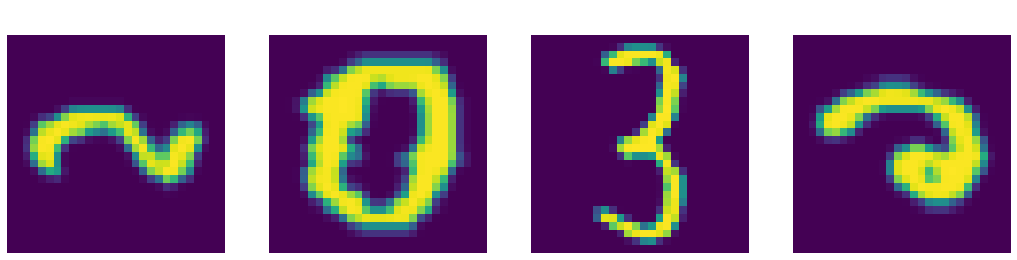

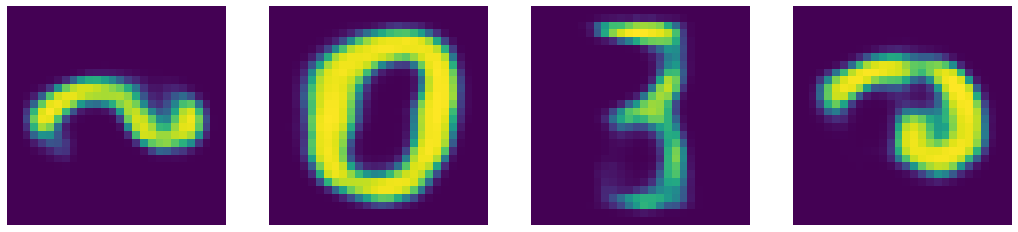

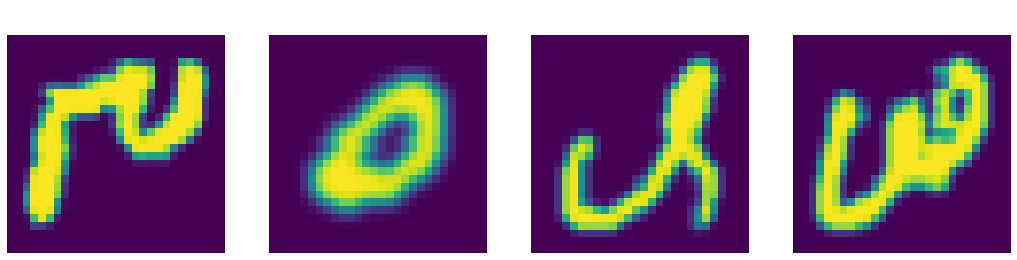

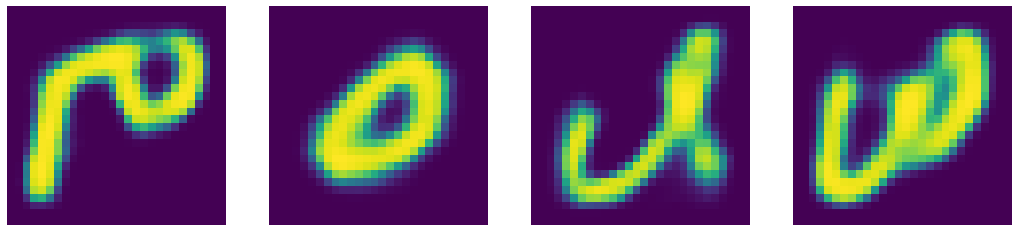

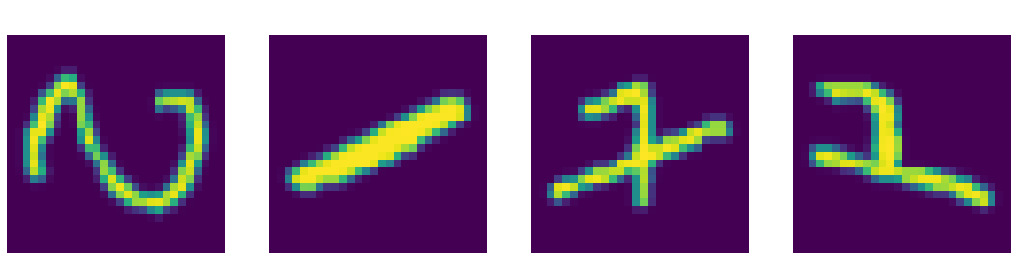

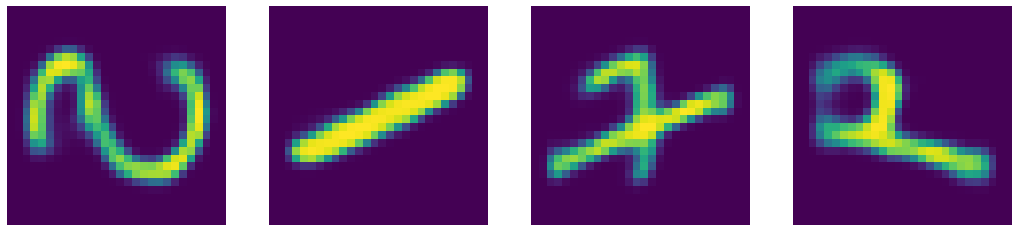

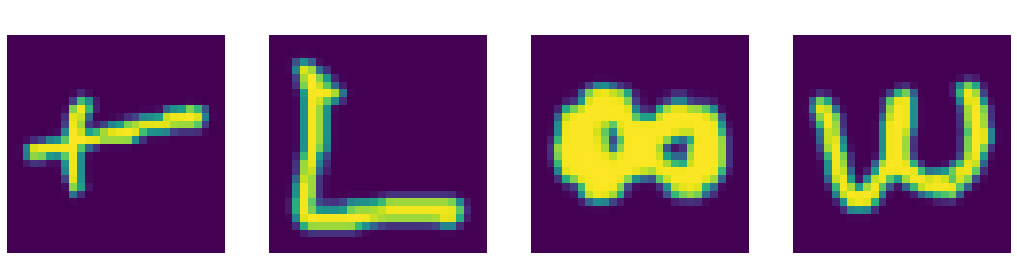

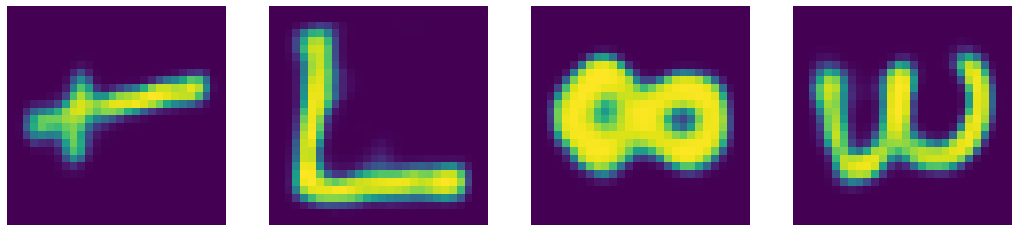

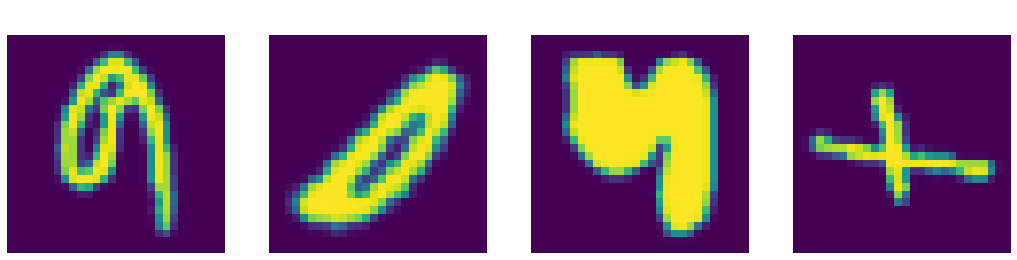

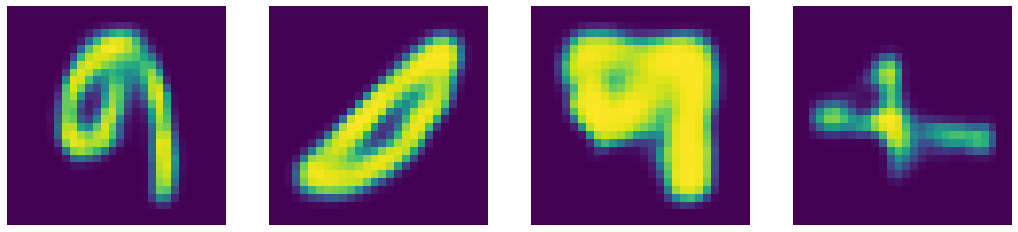

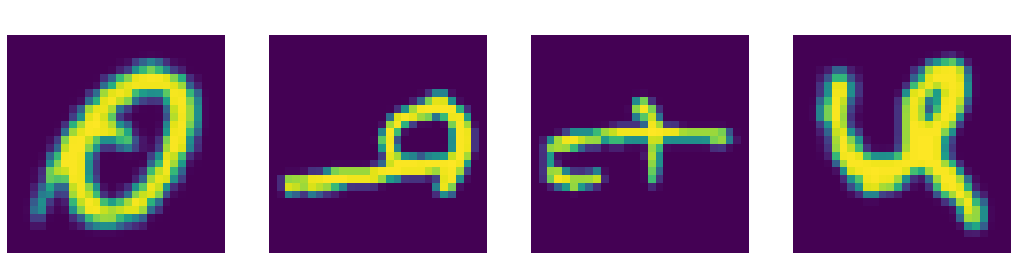

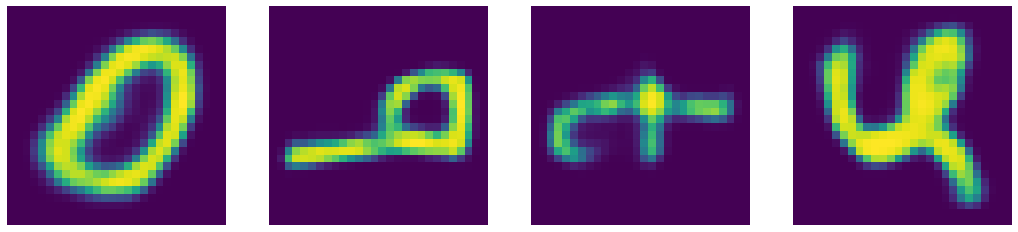

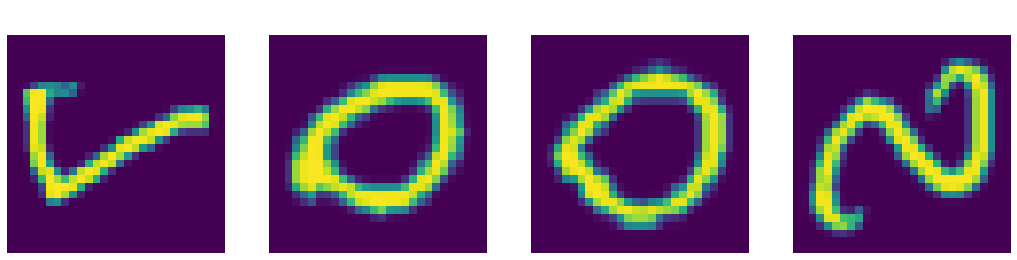

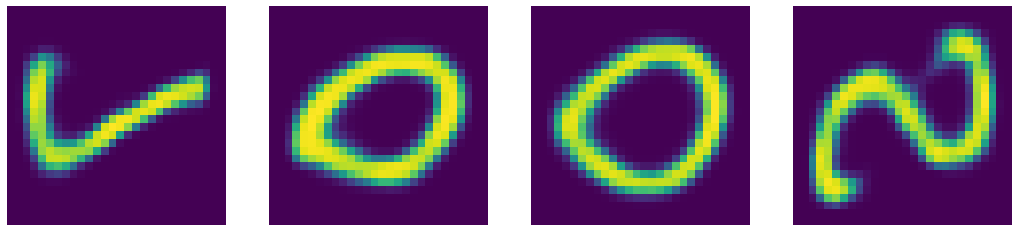

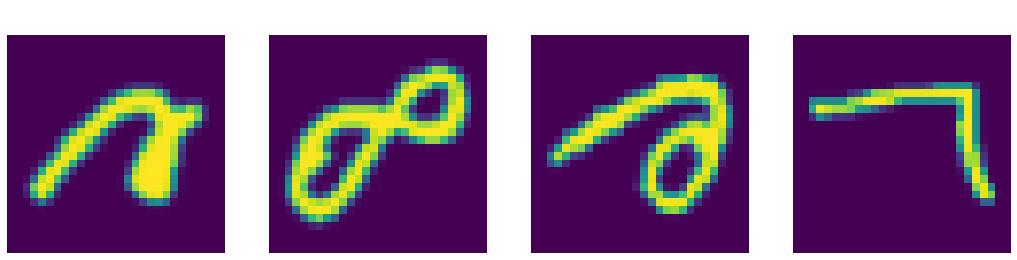

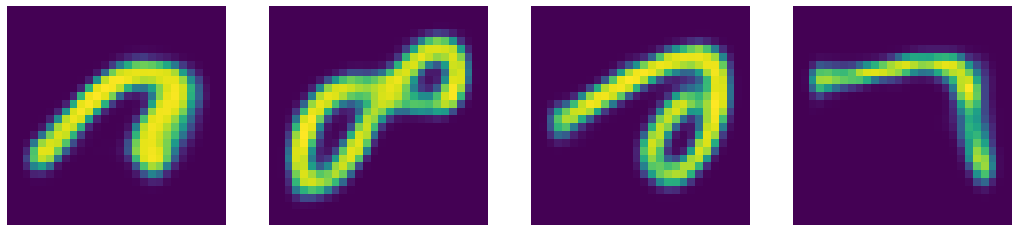

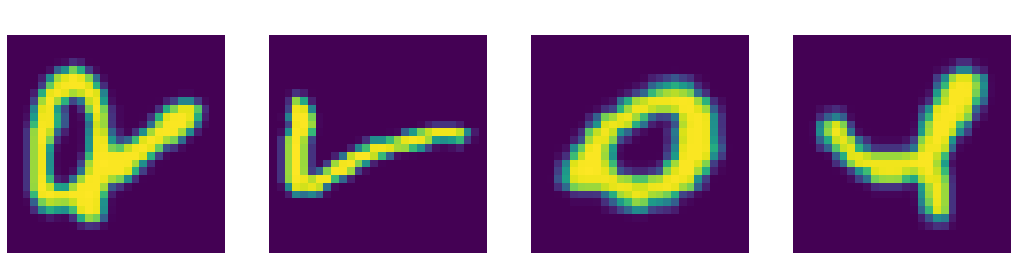

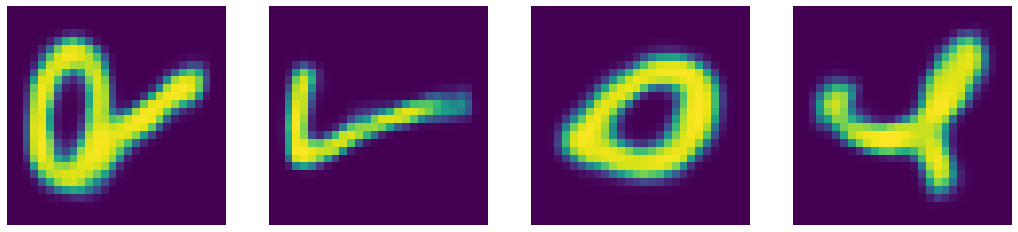

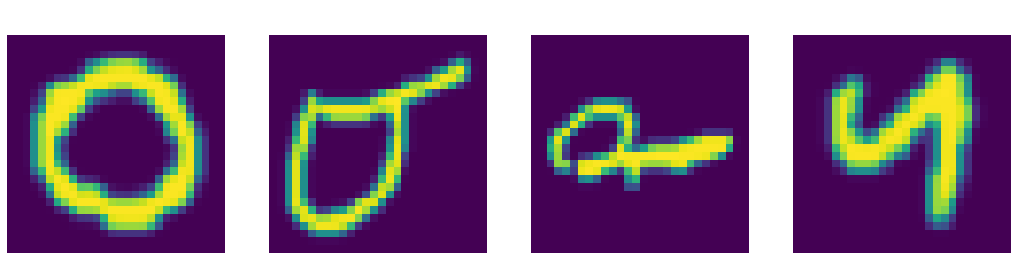

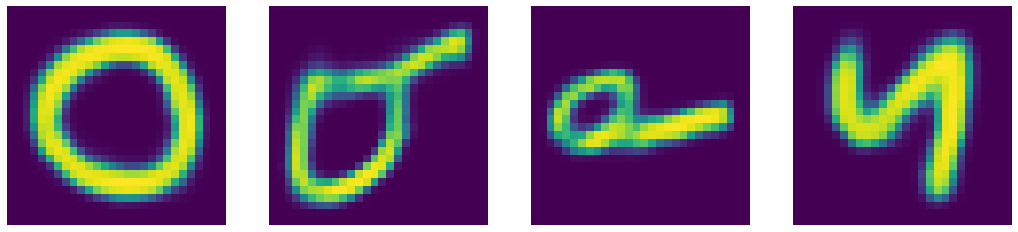

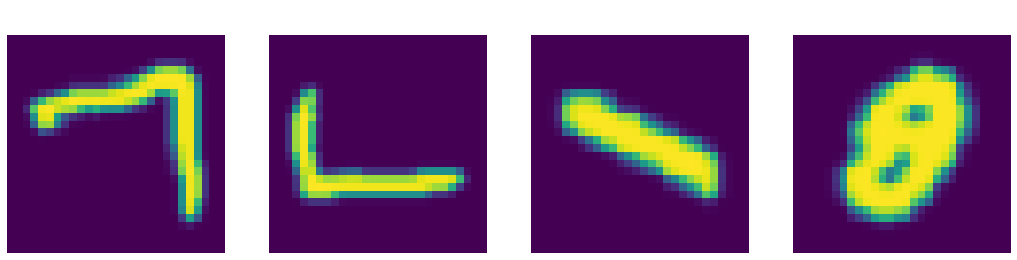

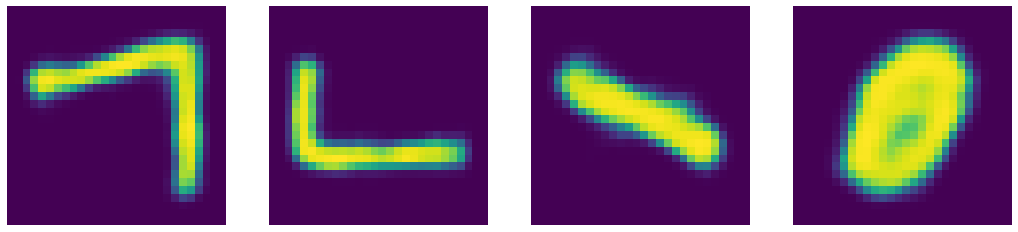

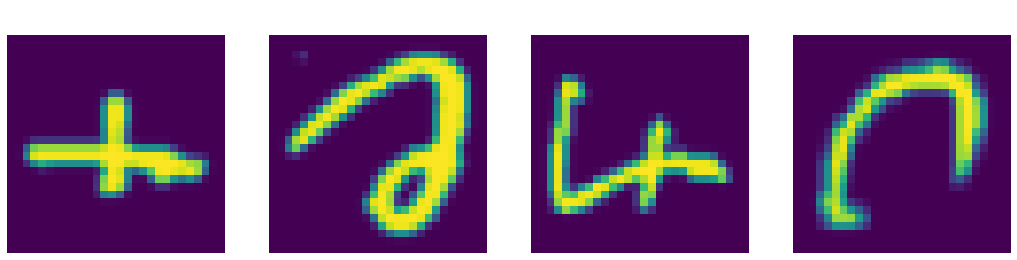

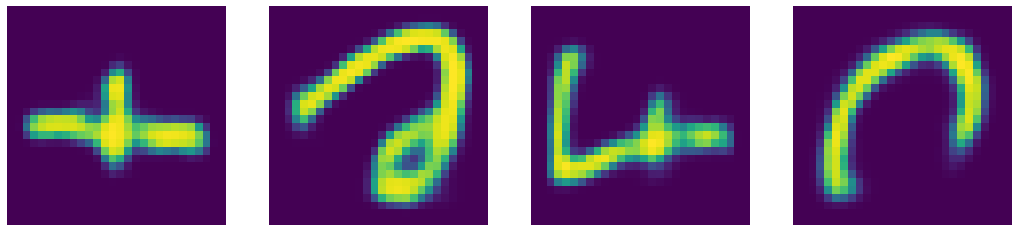

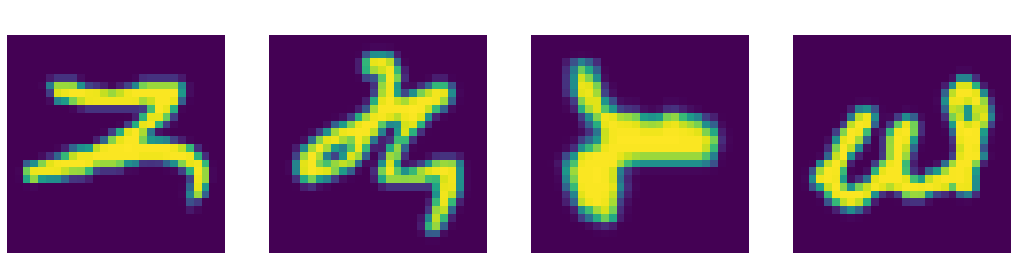

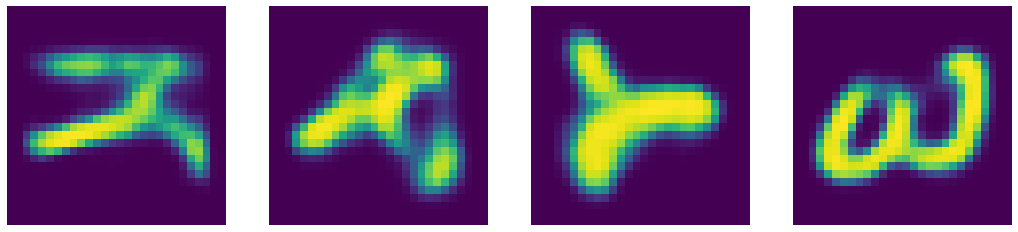

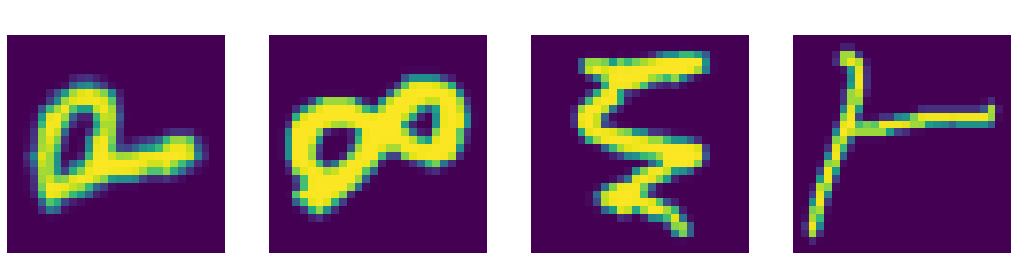

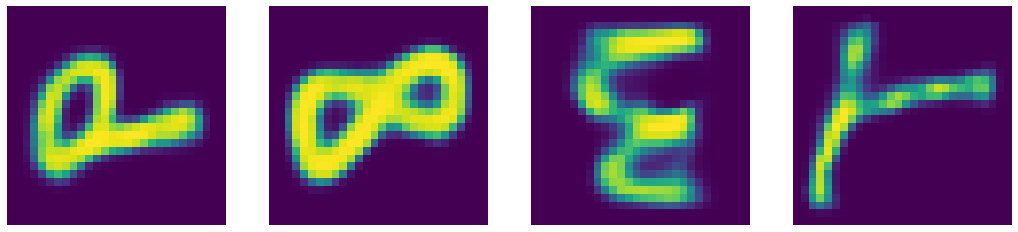

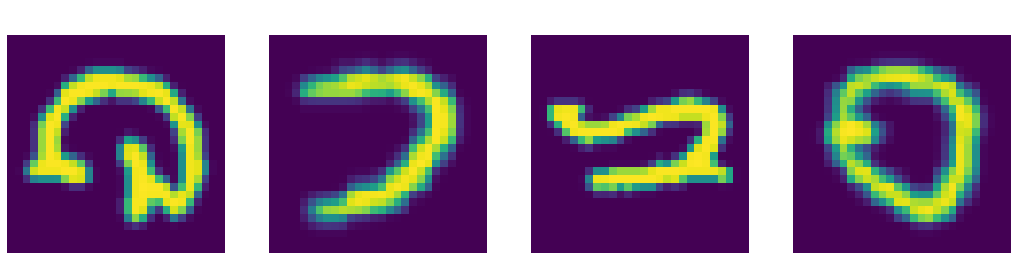

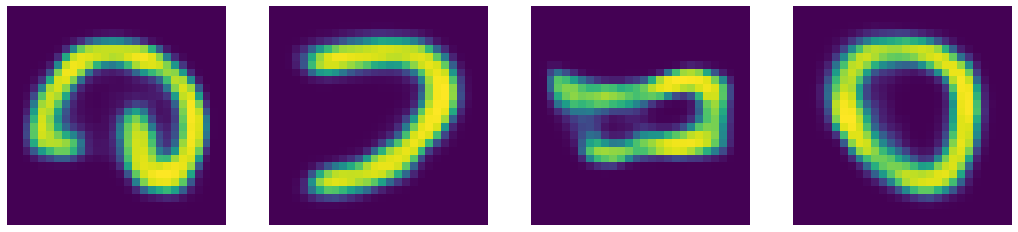

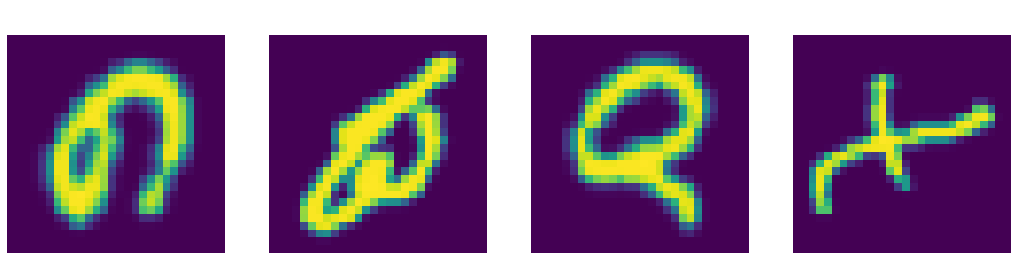

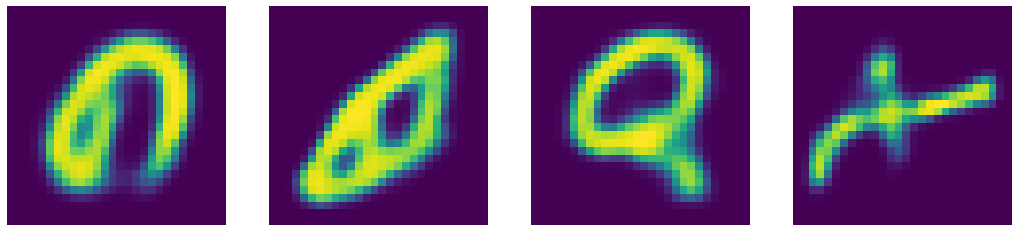

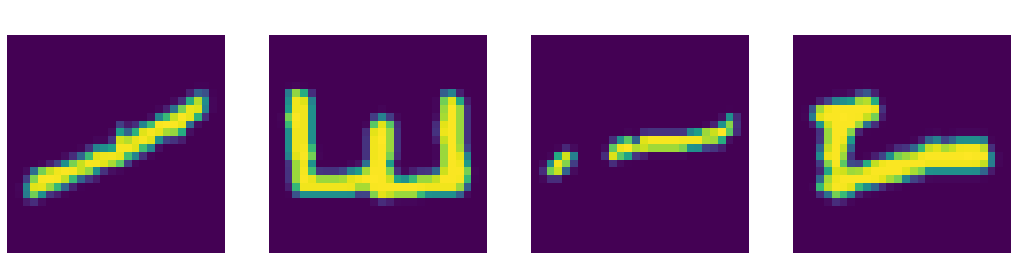

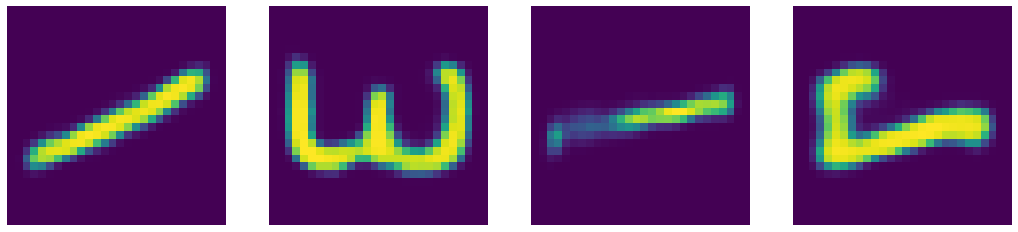

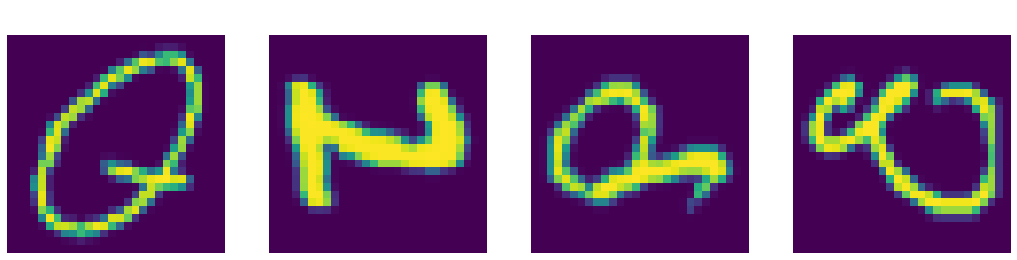

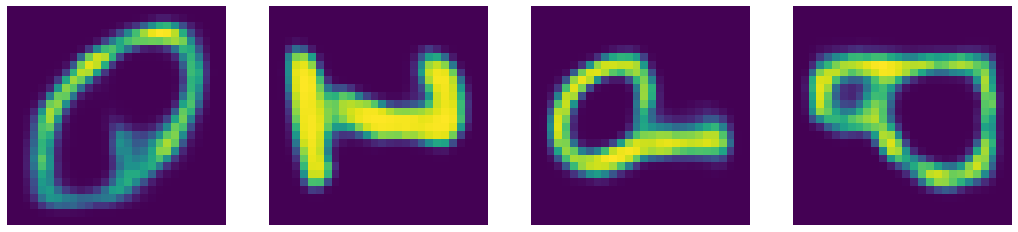

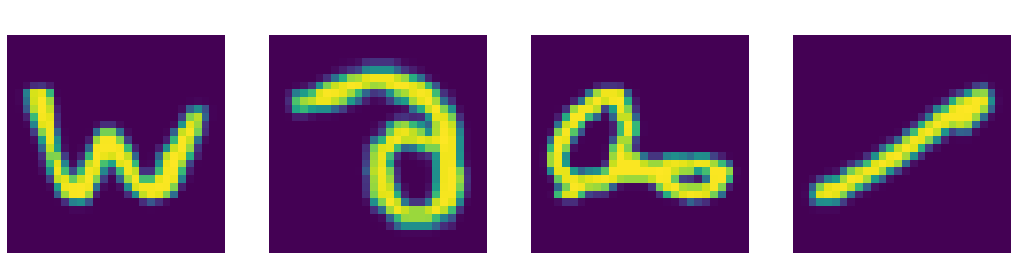

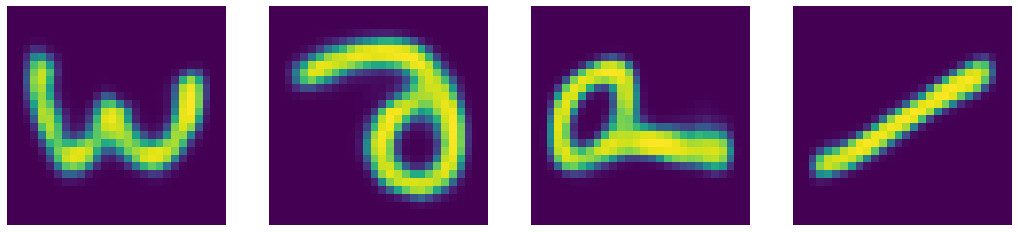

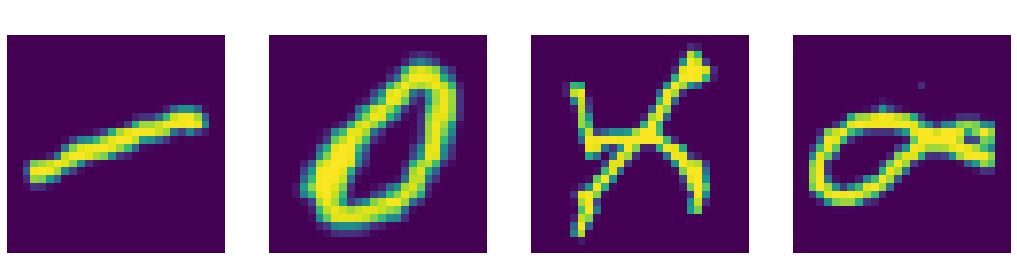

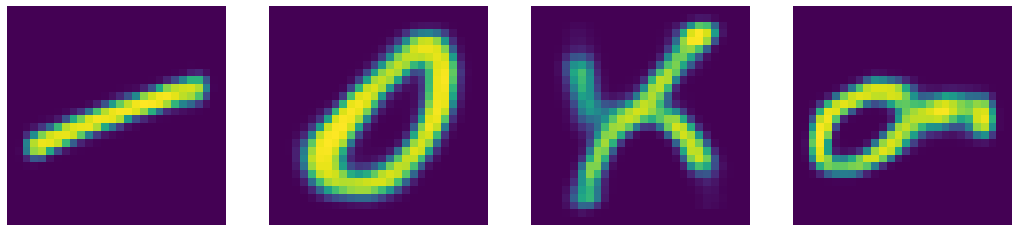

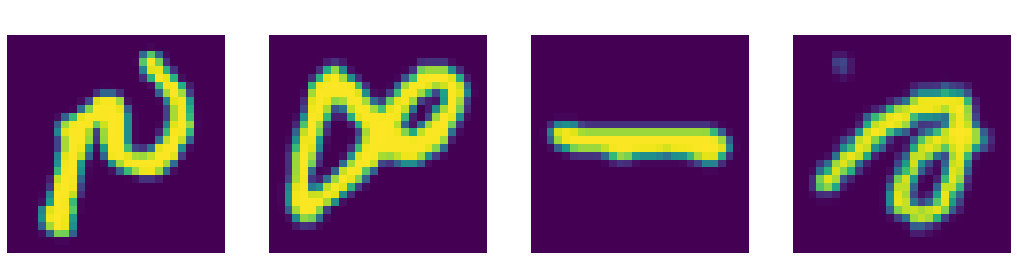

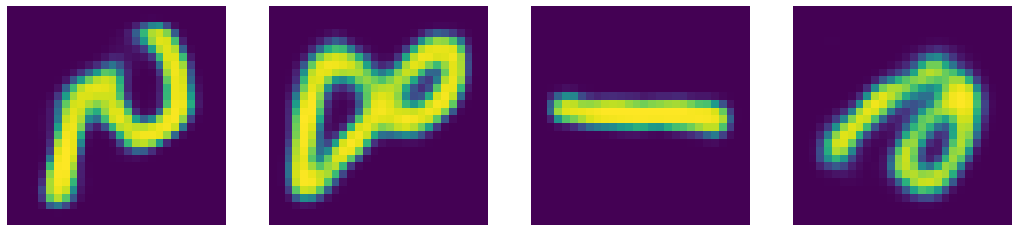

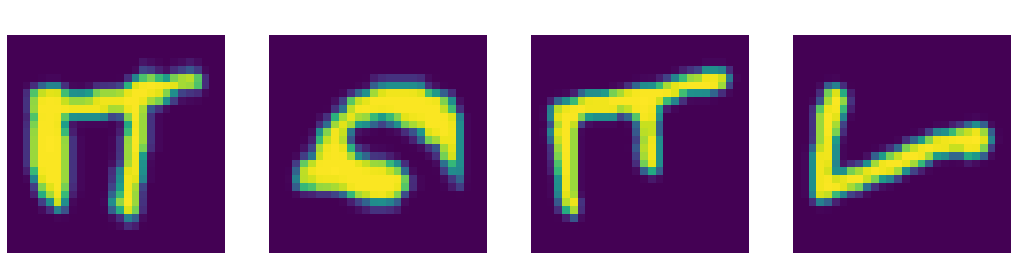

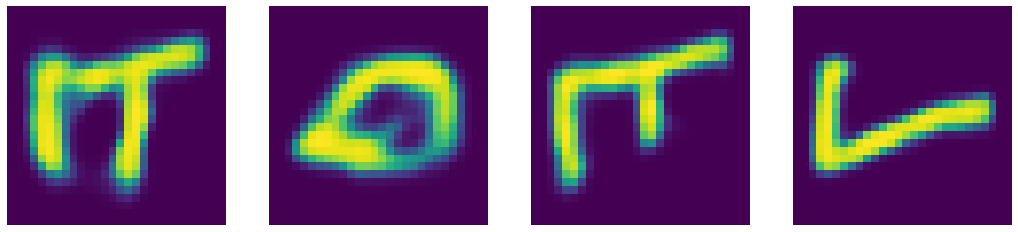

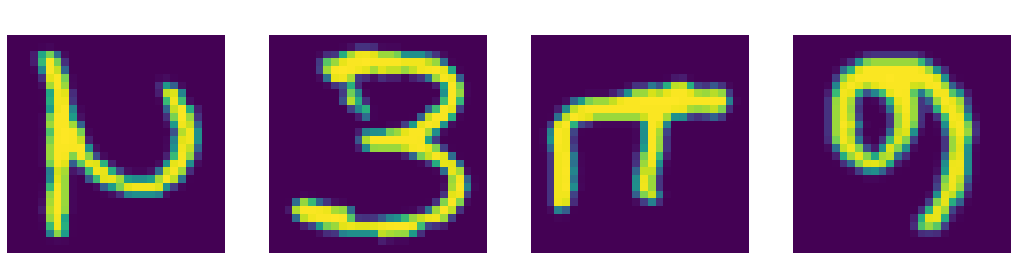

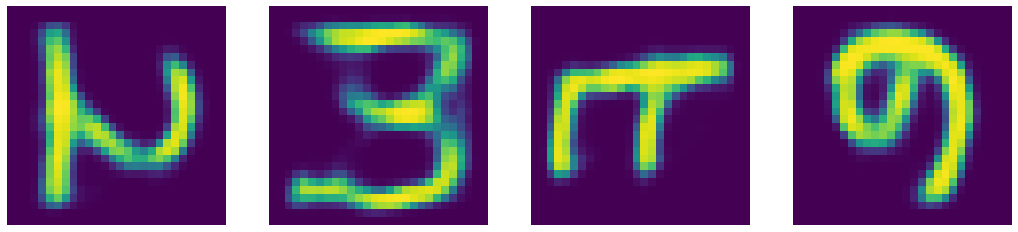

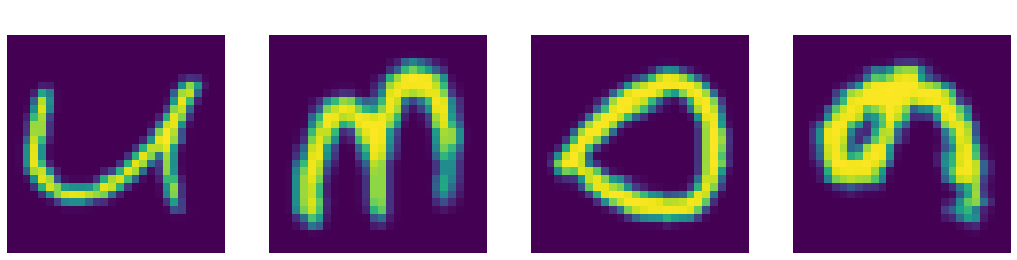

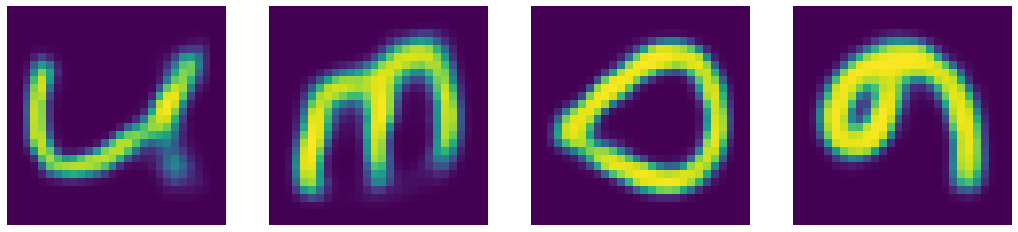

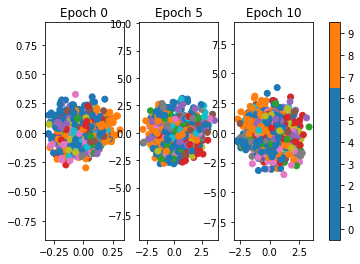

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Setting the optimiser

learning_rate = 1e-2
model = VAE(30).to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True}
codes = execute(epochs = 30,
        train_loader = torch.utils.data.DataLoader(
                        EMNIST('./data', train=True, download=True, split='byclass',
                        transform=transforms.ToTensor()),
                        batch_size=batch_size, shuffle=True, **kwargs),

        test_loader = torch.utils.data.DataLoader(
                      EMNIST('./data', train=False,split='byclass', transform=transforms.ToTensor()),
                      batch_size=batch_size, shuffle=True, **kwargs)
        )


plot(codes)

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5,10,15,20,25,30)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(PCA(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

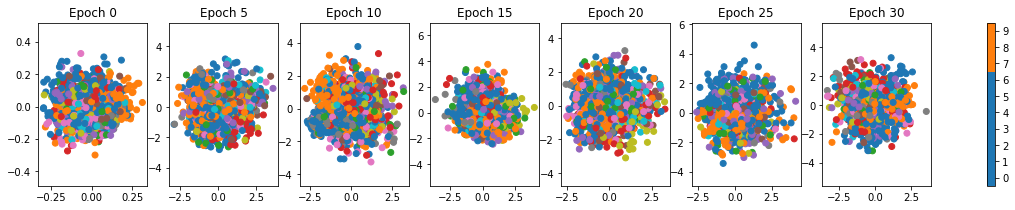

In [ ]:
f, a = plt.subplots(ncols=7,figsize=(20,3))
for i, e in enumerate(epochs):
    s = a[i].scatter(
        E[i][:,0],
        E[i][:,1],
        c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

<p>
Novamente, podemos ver que alguns pontos pertencentes a algumas classes tenderam a se agrupar, conforme o esperado, e a dispersão entre todos os pontos no mapa diminuiu ao longo das gerações. Entretanto, continuamos sem ter as classes claramente separadas e definidas, se as compararmos umas com as outras.
</p>